In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif, RFE, RFECV,
                                       SelectFromModel)
from sklearn.manifold import Isomap, LocallyLinearEmbedding

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, RepeatedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.cluster import (KMeans, MiniBatchKMeans, MeanShift, AgglomerativeClustering, DBSCAN,
                             AffinityPropagation, OPTICS)
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch

%matplotlib inline 

original = pd.read_csv('football.csv')
dataframe = original.copy()

original

name      club  age position  position_cat  market_value  \
0         Alexis Sanchez   Arsenal   28       LW             1          65.0   
1             Mesut Ozil   Arsenal   28       AM             1          50.0   
2              Petr Cech   Arsenal   35       GK             4           7.0   
3           Theo Walcott   Arsenal   28       RW             1          20.0   
4      Laurent Koscielny   Arsenal   31       CB             3          22.0   
..                   ...       ...  ...      ...           ...           ...   
456  Edimilson Fernandes  West+Ham   21       CM             2           5.0   
457       Arthur Masuaku  West+Ham   23       LB             3           7.0   
458            Sam Byram  West+Ham   23       RB             3           4.5   
459      Ashley Fletcher  West+Ham   21       CF             1           1.0   
460         Diafra Sakho  West+Ham   27       CF             1          10.0   

     page_views  fpl_value fpl_sel  fpl_points  region     nationality  \
0          4329       12.0  17.10%         264       3           Chile   
1          4395        9.5   5.60%         167       2         Germany   
2          1529        5.5   5.90%         134       2  Czech Republic   
3          2393        7.5   1.50%         122       1         England   
4           912        6.0   0.70%         121       2          France   
..          ...        ...     ...         ...     ...             ...   
456         288        4.5   0.40%          38       2     Switzerland   
457         199        4.5   0.20%          34       4        Congo DR   
458         198        4.5   0.30%          29       1         England   
459         412        4.5   5.90%          16       1         England   
460         214        5.5   0.10%          12       4         Senegal   

     new_foreign  age_cat  club_id  big_club  new_signing  
0              0        4        1         1            0  
1              0        4        1         1            0  
2              0        6        1         1            0  
3              0        4        1         1            0  
4              0        4        1         1            0  
..           ...      ...      ...       ...          ...  
456            0        1       20         0            1  
457            0        2       20         0            1  
458            0        2       20         0            0  
459            0        1       20         0            1  
460            0        3       20         0            0  

[461 rows x 17 columns]

In [2]:
print('Missing values:')
original.isnull().sum()

Missing values:


name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_value       0
fpl_sel         0
fpl_points      0
region          0
nationality     0
new_foreign     0
age_cat         0
club_id         0
big_club        0
new_signing     0
dtype: int64

In [3]:
print('Basic info:')
original.info()

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          461 non-null    object 
 1   club          461 non-null    object 
 2   age           461 non-null    int64  
 3   position      461 non-null    object 
 4   position_cat  461 non-null    int64  
 5   market_value  461 non-null    float64
 6   page_views    461 non-null    int64  
 7   fpl_value     461 non-null    float64
 8   fpl_sel       461 non-null    object 
 9   fpl_points    461 non-null    int64  
 10  region        461 non-null    int64  
 11  nationality   461 non-null    object 
 12  new_foreign   461 non-null    int64  
 13  age_cat       461 non-null    int64  
 14  club_id       461 non-null    int64  
 15  big_club      461 non-null    int64  
 16  new_signing   461 non-null    int64  
dtypes: float64(2), int64(10), object(5)
memory usage: 61.4+ KB


In [4]:
valid = np.r_[2, 4:8, 9, 10, 12:17]

print('All-in-one statistics:')
original.describe(include='all')

All-in-one statistics:


name          club         age position  position_cat  \
count               461           461  461.000000      461    461.000000   
unique              461            20         NaN       13           NaN   
top     Hal Robson-Kanu  Huddersfield         NaN       CB           NaN   
freq                  1            28         NaN       85           NaN   
mean                NaN           NaN   26.804772      NaN      2.180043   
std                 NaN           NaN    3.961892      NaN      1.000061   
min                 NaN           NaN   17.000000      NaN      1.000000   
25%                 NaN           NaN   24.000000      NaN      1.000000   
50%                 NaN           NaN   27.000000      NaN      2.000000   
75%                 NaN           NaN   30.000000      NaN      3.000000   
max                 NaN           NaN   38.000000      NaN      4.000000   

        market_value   page_views   fpl_value fpl_sel  fpl_points      region  \
count     461.000000   461.000000  461.000000     461  461.000000  461.000000   
unique           NaN          NaN         NaN     113         NaN         NaN   
top              NaN          NaN         NaN   0.10%         NaN         NaN   
freq             NaN          NaN         NaN      64         NaN         NaN   
mean       11.012039   763.776573    5.447939     NaN   57.314534    1.997831   
std        12.257403   931.805757    1.346695     NaN   53.113811    0.961202   
min         0.050000     3.000000    4.000000     NaN    0.000000    1.000000   
25%         3.000000   220.000000    4.500000     NaN    5.000000    1.000000   
50%         7.000000   460.000000    5.000000     NaN   51.000000    2.000000   
75%        15.000000   896.000000    5.500000     NaN   94.000000    2.000000   
max        75.000000  7664.000000   12.500000     NaN  264.000000    4.000000   

       nationality  new_foreign     age_cat     club_id    big_club  \
count          461   461.000000  461.000000  461.000000  461.000000   
unique          61          NaN         NaN         NaN         NaN   
top        England          NaN         NaN         NaN         NaN   
freq           156          NaN         NaN         NaN         NaN   
mean           NaN     0.034707    3.206074   10.334056    0.303688   
std            NaN     0.183236    1.279795    5.726475    0.460349   
min            NaN     0.000000    1.000000    1.000000    0.000000   
25%            NaN     0.000000    2.000000    6.000000    0.000000   
50%            NaN     0.000000    3.000000   10.000000    0.000000   
75%            NaN     0.000000    4.000000   15.000000    1.000000   
max            NaN     1.000000    6.000000   20.000000    1.000000   

        new_signing  
count    461.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       0.145336  
std        0.352822  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [5]:
print('Column\'s means:')
original[original.columns[valid]].mean()

Column's means:


age              26.804772
position_cat      2.180043
market_value     11.012039
page_views      763.776573
fpl_value         5.447939
fpl_points       57.314534
region            1.997831
new_foreign       0.034707
age_cat           3.206074
club_id          10.334056
big_club          0.303688
new_signing       0.145336
dtype: float64

In [6]:
print('Column\'s medians:)')
original[original.columns[valid]].median()

Column's medians:)


age              27.0
position_cat      2.0
market_value      7.0
page_views      460.0
fpl_value         5.0
fpl_points       51.0
region            2.0
new_foreign       0.0
age_cat           3.0
club_id          10.0
big_club          0.0
new_signing       0.0
dtype: float64

In [7]:
print('Column\'s ranges (max - min):')
original[original.columns[valid]].max() - original[original.columns[valid]].min()

Column's ranges (max - min):


age               21.00
position_cat       3.00
market_value      74.95
page_views      7661.00
fpl_value          8.50
fpl_points       264.00
region             3.00
new_foreign        1.00
age_cat            5.00
club_id           19.00
big_club           1.00
new_signing        1.00
dtype: float64

In [8]:
print('Column\'s standard deviations:')
original[original.columns[valid]].std()

Column's standard deviations:


age               3.961892
position_cat      1.000061
market_value     12.257403
page_views      931.805757
fpl_value         1.346695
fpl_points       53.113811
region            0.961202
new_foreign       0.183236
age_cat           1.279795
club_id           5.726475
big_club          0.460349
new_signing       0.352822
dtype: float64

In [9]:
print('Column\'s variances:')
original[original.columns[valid]].var()

Column's variances:


age                 15.696586
position_cat         1.000123
market_value       150.243925
page_views      868261.969537
fpl_value            1.813588
fpl_points        2821.076940
region               0.923908
new_foreign          0.033575
age_cat              1.637876
club_id             32.792512
big_club             0.211921
new_signing          0.124484
dtype: float64

Text(0.5, 1.0, 'Correlation Heatmap')

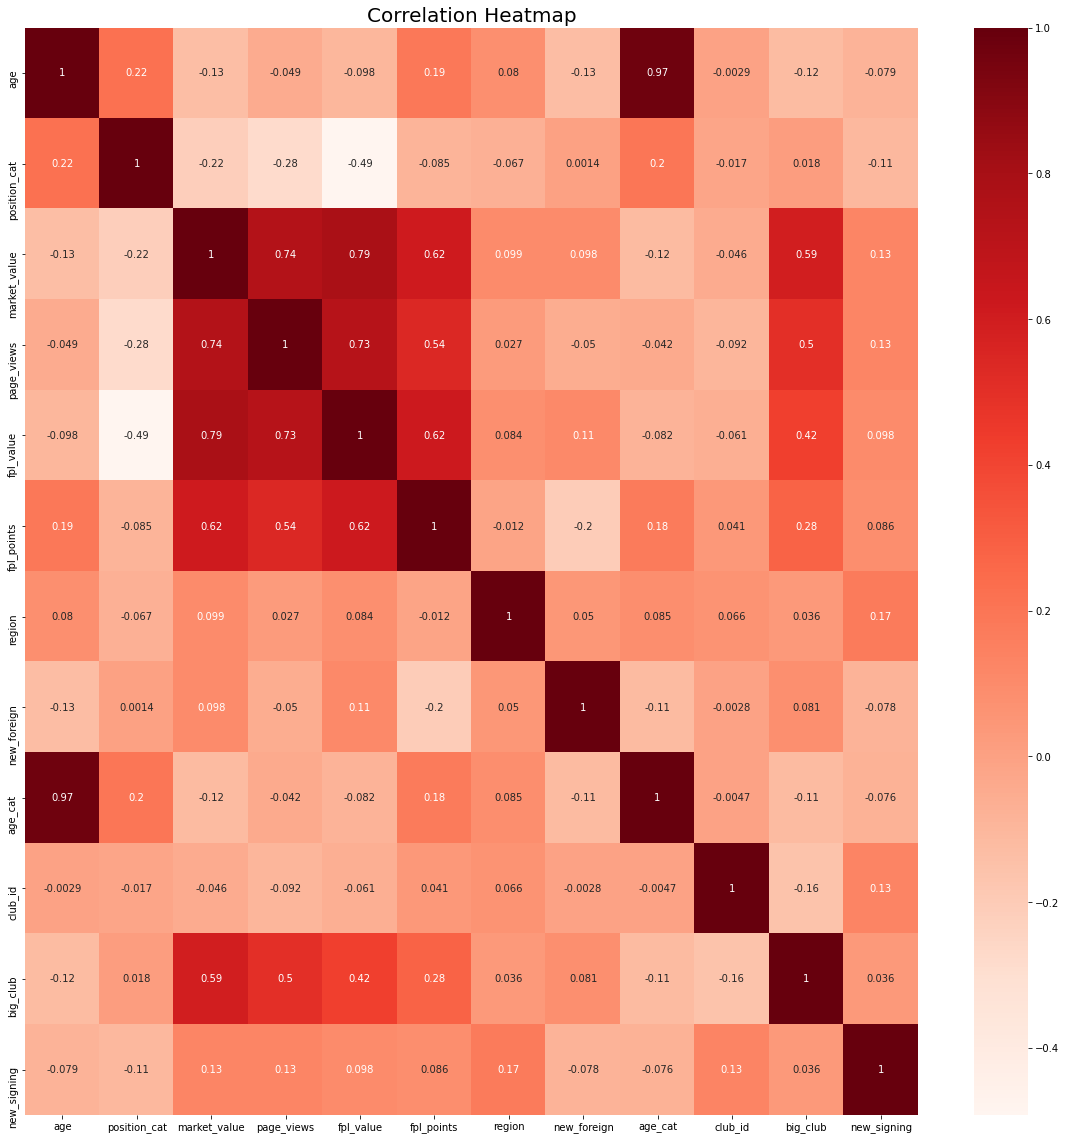

In [10]:
corr_matrix = original.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap="Reds")
plt.title('Correlation Heatmap', fontsize=20)

Triangle matrix correlation:


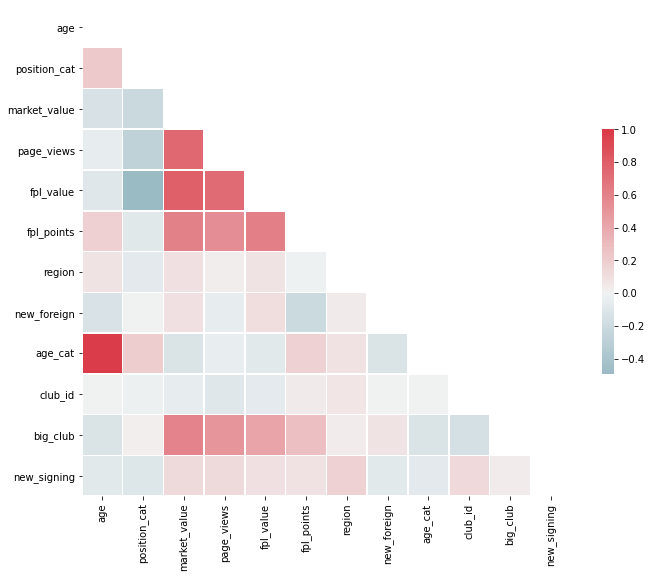

In [11]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
print('Triangle matrix correlation:')    
plot_corr(original)

In [12]:
dataframe = original.copy()
dataframe.drop(['name', 'club', 'position', 'fpl_sel', 'nationality'], axis=1, inplace=True)

dataframe

age  position_cat  market_value  page_views  fpl_value  fpl_points  \
0     28             1          65.0        4329       12.0         264   
1     28             1          50.0        4395        9.5         167   
2     35             4           7.0        1529        5.5         134   
3     28             1          20.0        2393        7.5         122   
4     31             3          22.0         912        6.0         121   
..   ...           ...           ...         ...        ...         ...   
456   21             2           5.0         288        4.5          38   
457   23             3           7.0         199        4.5          34   
458   23             3           4.5         198        4.5          29   
459   21             1           1.0         412        4.5          16   
460   27             1          10.0         214        5.5          12   

     region  new_foreign  age_cat  club_id  big_club  new_signing  
0         3            0        4        1         1            0  
1         2            0        4        1         1            0  
2         2            0        6        1         1            0  
3         1            0        4        1         1            0  
4         2            0        4        1         1            0  
..      ...          ...      ...      ...       ...          ...  
456       2            0        1       20         0            1  
457       4            0        2       20         0            1  
458       1            0        2       20         0            0  
459       1            0        1       20         0            1  
460       4            0        3       20         0            0  

[461 rows x 12 columns]

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           461 non-null    int64  
 1   position_cat  461 non-null    int64  
 2   market_value  461 non-null    float64
 3   page_views    461 non-null    int64  
 4   fpl_value     461 non-null    float64
 5   fpl_points    461 non-null    int64  
 6   region        461 non-null    int64  
 7   new_foreign   461 non-null    int64  
 8   age_cat       461 non-null    int64  
 9   club_id       461 non-null    int64  
 10  big_club      461 non-null    int64  
 11  new_signing   461 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 43.3 KB


<AxesSubplot:xlabel='new_signing', ylabel='count'>

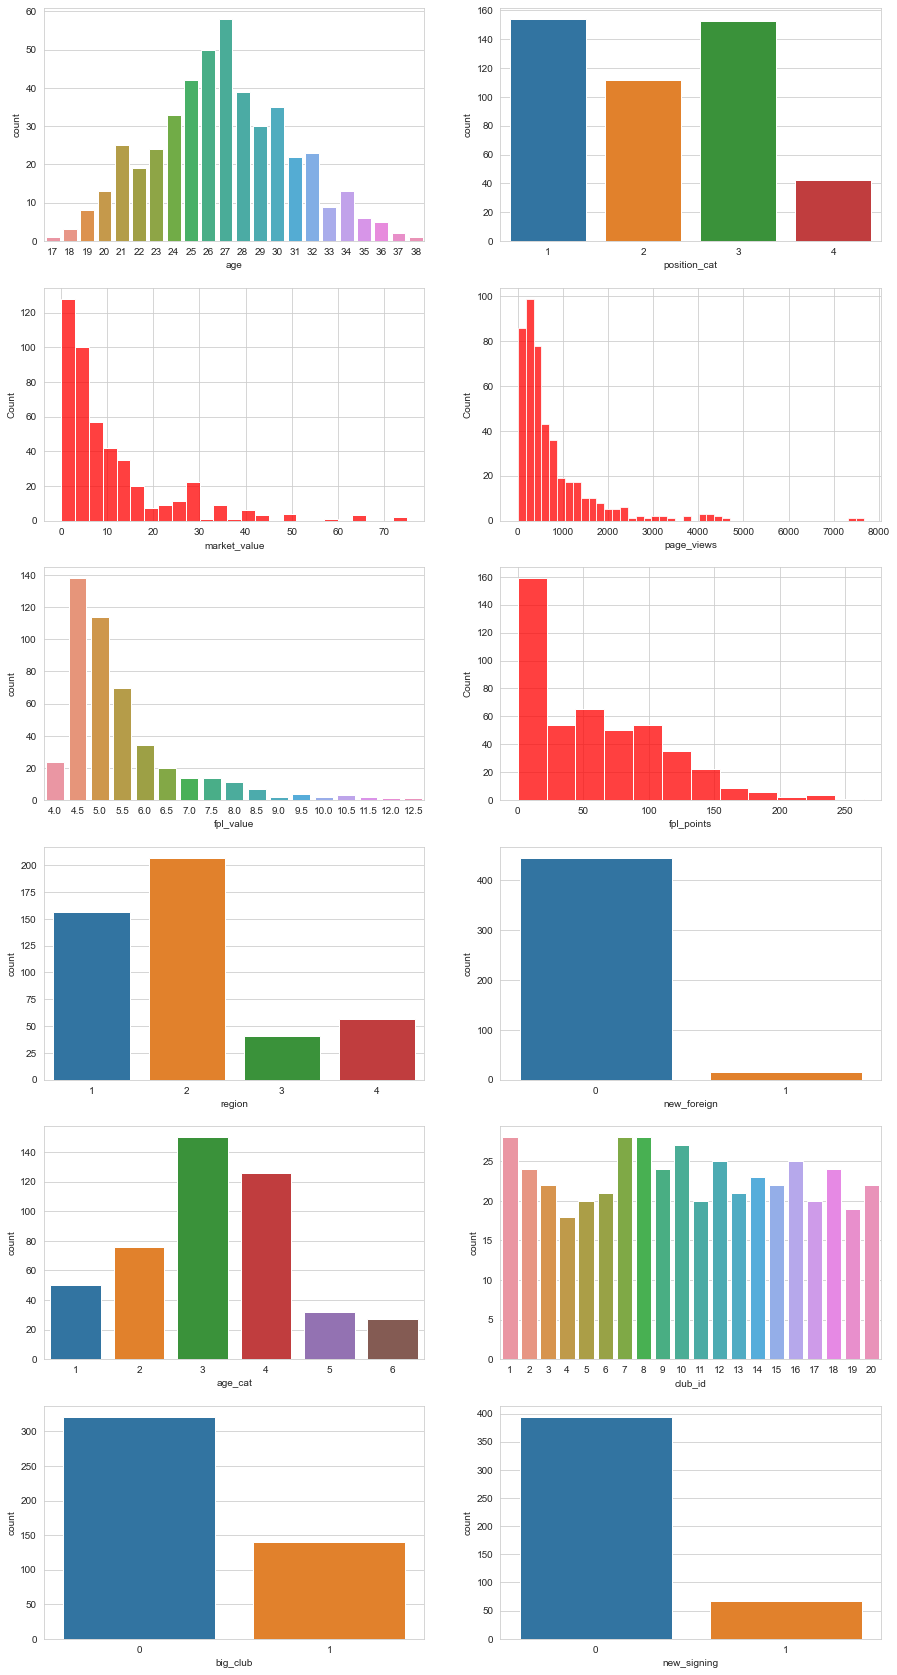

In [14]:
sns.set_style('whitegrid')
fig1, axs1 = plt.subplots(6, 2, figsize=(15, 30), num='Stats visualised')

sns.countplot(x=dataframe['age'], ax=axs1[0,0])
sns.countplot(x=dataframe['position_cat'], ax=axs1[0,1])
sns.histplot(x=dataframe['market_value'], ax=axs1[1,0], color='red') #
sns.histplot(x=dataframe['page_views'], ax=axs1[1,1], color='red')  #
sns.countplot(x=dataframe['fpl_value'], ax=axs1[2,0])
sns.histplot(x=dataframe['fpl_points'], ax=axs1[2,1], color='red')  #
sns.countplot(x=dataframe['region'], ax=axs1[3,0])
sns.countplot(x=dataframe['new_foreign'], ax=axs1[3,1])
sns.countplot(x=dataframe['age_cat'], ax=axs1[4,0])
sns.countplot(x=dataframe['club_id'], ax=axs1[4,1])
sns.countplot(x=dataframe['big_club'], ax=axs1[5,0])
sns.countplot(x=dataframe['new_signing'], ax=axs1[5,1])

In [15]:
# pomocne funkcije za osnovni 2D i 3D prikaz, kao i standardno skaliranje i merenje modela
def _show_2d(features, target, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=dataframe[target], s=50)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def _show_3d(features, target, xlabel, ylabel, zlabel):
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(features[:, 0], features[:, 1], features[:, 2], c=dataframe[target], alpha=0.6, s=50)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)


def do_StandardScaling(drop=None):
    df = dataframe
    if drop:
        df = dataframe.drop(drop, axis=1)
    features = StandardScaler().fit_transform(df)
    return features

def _measure(model, feat, target, strat=False, scoring='neg_mean_absolute_error'):
    if strat:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    else:
        cv = RepeatedKFold(n_splits=10, n_repeats=3)

    n_scores = cross_val_score(model, feat, dataframe[target], scoring=scoring, cv=cv, n_jobs=-1)
    print(f'Accuracy: {np.mean(n_scores):.3f} ({np.std(n_scores)}:.3f)')

## Feature Extraction

### PCA

In [16]:
def do_PCA(n_components=0.9, whiten=True, components=False, target='big_club', ss=True):
    features = do_StandardScaling() if ss else dataframe
    pca = PCA(n_components=n_components, whiten=whiten)
    fit = pca.fit(features)
    features_pca = pca.fit_transform(features)
    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_pca.shape[1]}')
    print(f'Explained variance: {fit.explained_variance_ratio_}')
    print(f'Explained variance sum: {round(sum(fit.explained_variance_ratio_), 2)}')
    print(f'Explained variance cumulative sum: {np.cumsum(fit.explained_variance_ratio_ * 100)}')
    if components:
        print(f'Components: {fit.components_}')

    if n_components == 2:
        _show_2d(features_pca, target, 'Fist principal component', 'Second principal component')
    elif n_components == 3:
        _show_3d(features_pca, target, 'First principal component', 'Second principal component',
                 'Third principal component')
    else:
        if n_components < 1:
            plt.figure(figsize=(12, 8))
            plt.plot(features_pca)
            plt.title(f'Transformed data by the principal components - {n_components * 100}% variablity', pad=15)
            plt.xlabel('Observations')
            plt.ylabel('Transformed data')
            print(f'{features_pca.shape} components to preserve {n_components * 100} of the variability in data')

        plt.figure(figsize=(12, 8))
        plt.plot(np.cumsum(fit.explained_variance_ratio_))
        plt.xlabel('Number of components')
        plt.ylabel('Explained variance')

    return features_pca

Original number of features: 12
Reduced number of features: 2
Explained variance: [0.99757854 0.00229613]
Explained variance sum: 1.0
Explained variance cumulative sum: [99.75785398 99.98746723]


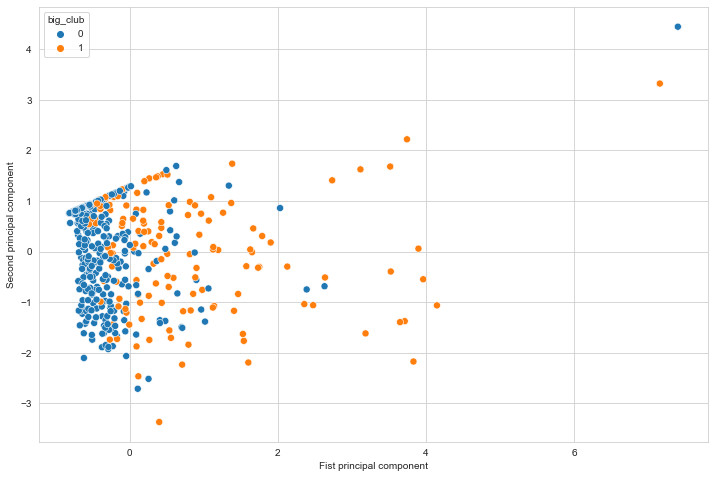

In [17]:
features_PCA_2_no_SS = do_PCA(2, ss=False)

Original number of features: 12
Reduced number of features: 3
Explained variance: [9.97578540e-01 2.29613252e-03 6.86109759e-05]
Explained variance sum: 1.0
Explained variance cumulative sum: [99.75785398 99.98746723 99.99432833]


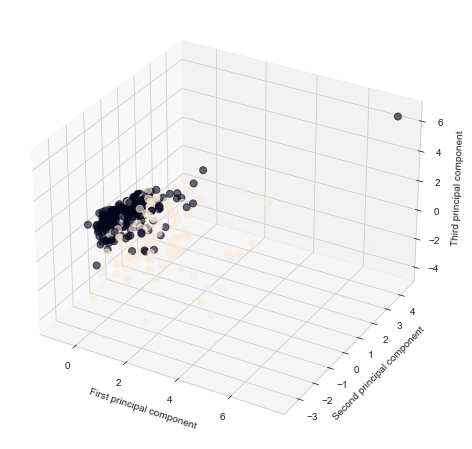

In [18]:
features_PCA_3_no_SS = do_PCA(3, ss=False)

Original number of features: 12
Reduced number of features: 2
Explained variance: [0.29529574 0.17872778]
Explained variance sum: 0.47
Explained variance cumulative sum: [29.52957447 47.40235279]


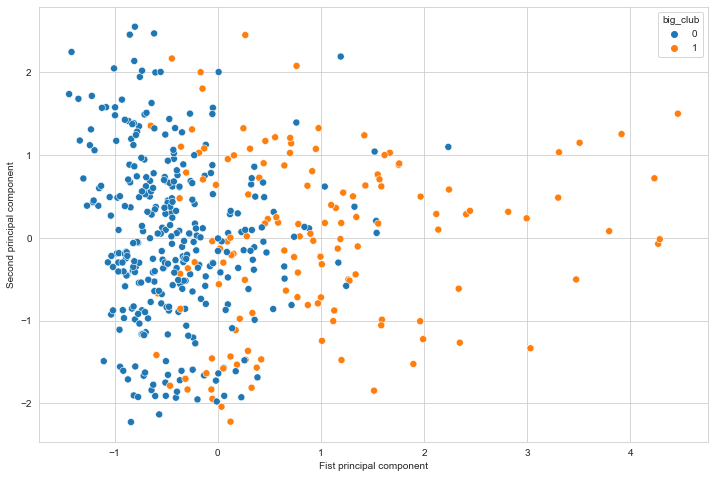

In [19]:
features_PCA_2 = do_PCA(2)

Original number of features: 12
Reduced number of features: 3
Explained variance: [0.29529574 0.17872778 0.10919814]
Explained variance sum: 0.58
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667 ]


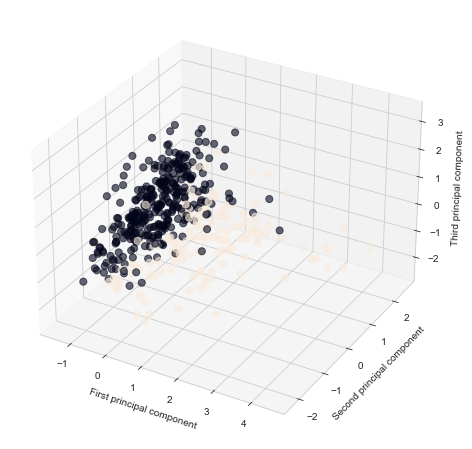

In [20]:
features_PCA_3 = do_PCA(3)

Original number of features: 12
Reduced number of features: 6
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788  0.07762087]
Explained variance sum: 0.84
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329 83.74207001]
(461, 6) components to preserve 80.0 of the variability in data


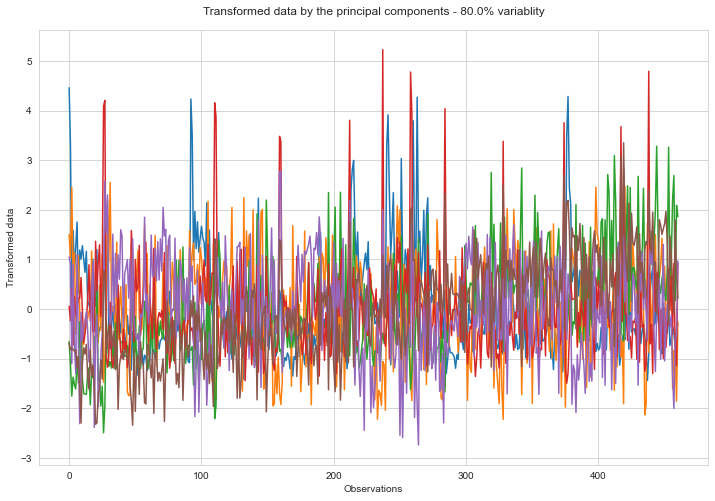

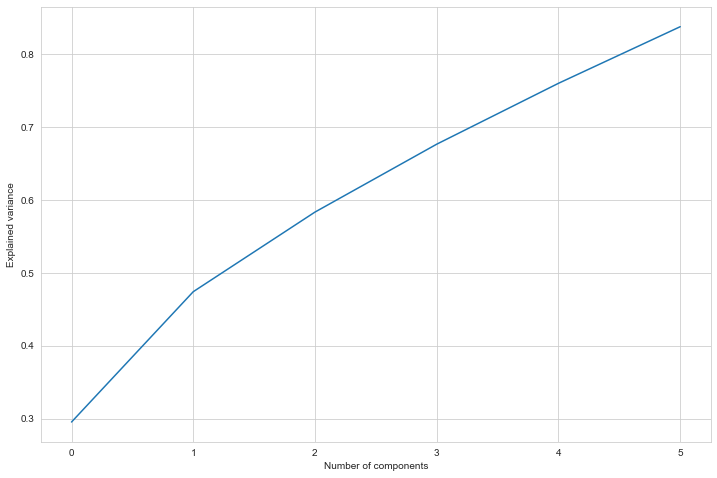

In [21]:
features_PCA_80p = do_PCA(.8)

Original number of features: 12
Reduced number of features: 8
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788  0.07762087
 0.0613634  0.04415543]
Explained variance sum: 0.94
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329 83.74207001
 89.87841032 94.29395378]
(461, 8) components to preserve 90.0 of the variability in data


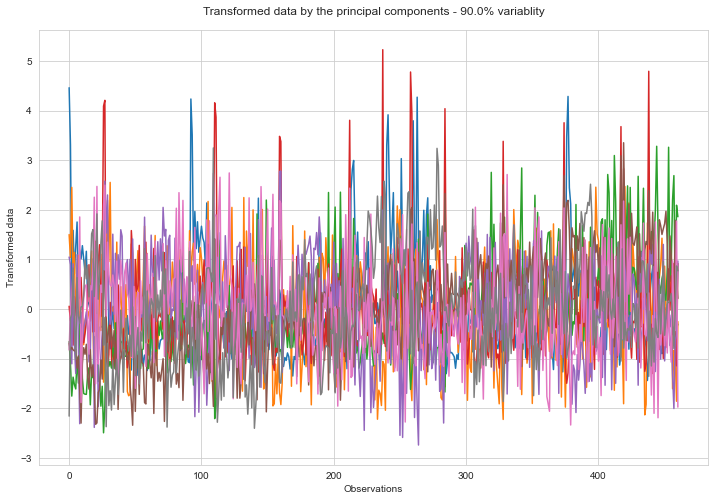

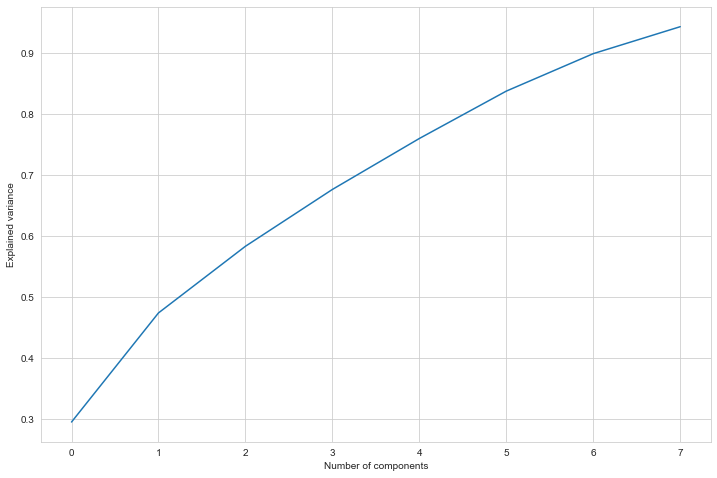

In [22]:
features_PCA_90p = do_PCA(.9)

Original number of features: 12
Reduced number of features: 9
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788  0.07762087
 0.0613634  0.04415543 0.02762707]
Explained variance sum: 0.97
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329 83.74207001
 89.87841032 94.29395378 97.05666067]
(461, 9) components to preserve 95.0 of the variability in data


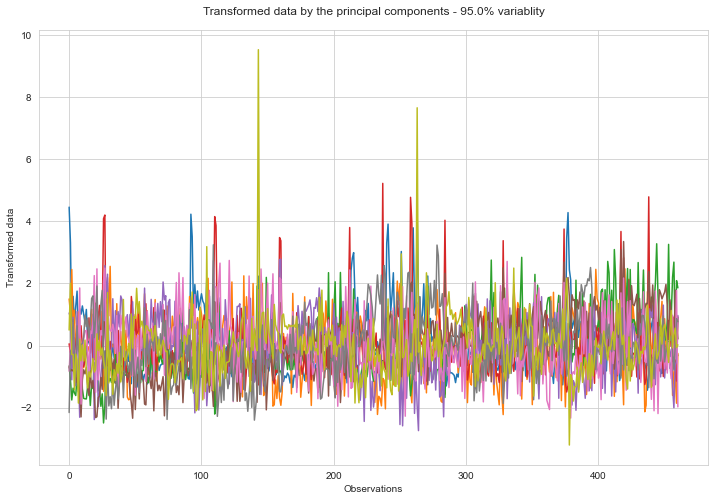

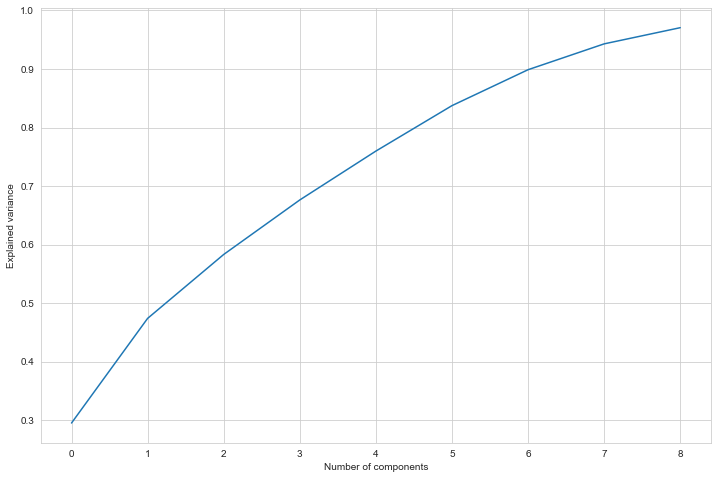

In [23]:
features_PCA_95p = do_PCA(.95)

### Kernel PCA

In [24]:
def do_KernelPCA(kernel='rbf', gamma=15, n_components=1, target='big_club', ss=True):
    features = do_StandardScaling() if ss else dataframe
    kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=n_components)
    features_kpca = kpca.fit_transform(features)
    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_kpca.shape[1]}')

    if n_components == 2:
        _show_2d(features_kpca, target, 'First principal component', 'Second principal component')
    elif n_components == 3:
        _show_3d(features_kpca, target, 'First principal component', 'Second principal component',
                 'Third principal component')

Original number of features: 12
Reduced number of features: 2


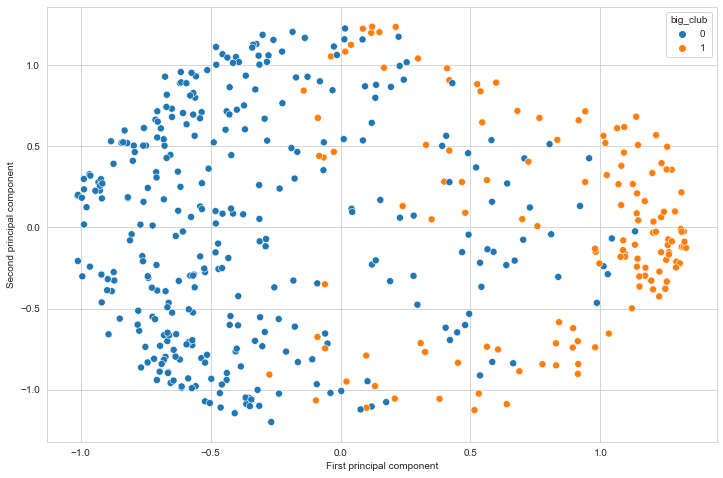

In [25]:
features_kpca_sigmoid_2 = do_KernelPCA(kernel='sigmoid', n_components = 2)

Original number of features: 12
Reduced number of features: 3


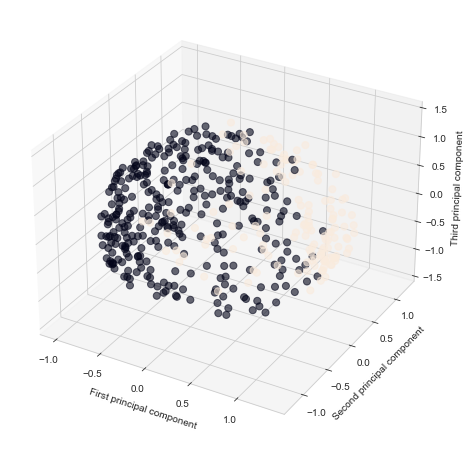

In [26]:
features_kpca_sigmoid_3 = do_KernelPCA(kernel='sigmoid', n_components = 3)

### Linear Discriminant Analysis

In [27]:
def do_LDA(n_components=1, target='big_club', goal_var=0.9, ss=False):
    features = do_StandardScaling(target) if ss else dataframe.drop(target, axis=1)
    if n_components:
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        features_lda = lda.fit(features, dataframe[target]).transform(features)
        print(f'Original number of features: {features.shape[1]}')
        print(f'Reduced number of features: {features_lda.shape[1]}')
        print(f'{lda.explained_variance_ratio_} = {np.cumsum(lda.explained_variance_ratio_)}')

        if n_components == 2:
            _show_2d(features_lda, target, 'First component', 'Second component')
        elif n_components == 3:
            _show_3d(features_lda, target, 'First component', 'Second component', 'Third component')

        return features_lda
    else:
        lda = LinearDiscriminantAnalysis(n_components=None).fit(features, dataframe[target])
        lda_var_ratios = lda.explained_variance_ratio_
        total_variance = 0.0
        n_components = 0
        for explained_variance in lda_var_ratios:
            total_variance += explained_variance
            n_components += 1
            if total_variance >= goal_var:
                break
        do_LDA(n_components=n_components, target=target)

In [28]:
features_LDA = do_LDA()

Original number of features: 11
Reduced number of features: 1
[1.] = [1.]


Original number of features: 11
Reduced number of features: 2
[0.93794004 0.03453798] = [0.93794004 0.97247802]


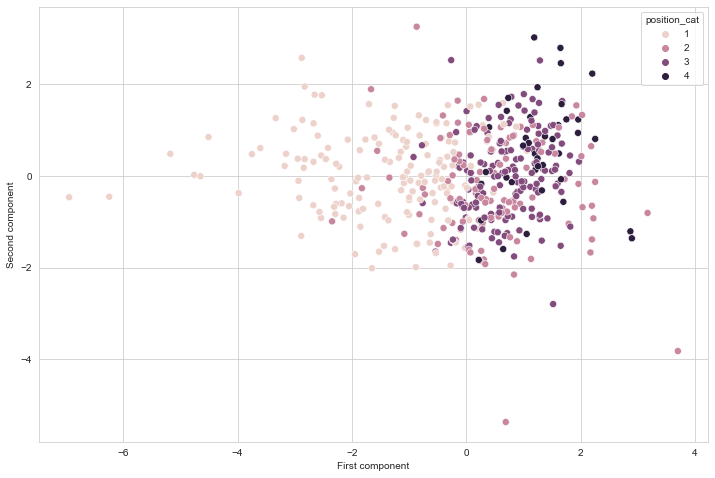

In [29]:
features_LDA_2 = do_LDA(2, target='position_cat')

Original number of features: 11
Reduced number of features: 3
[0.93794004 0.03453798 0.02752198] = [0.93794004 0.97247802 1.        ]


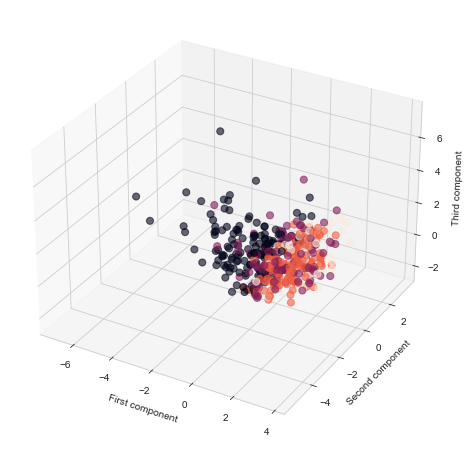

In [30]:
features_LDA_3 = do_LDA(3, target='position_cat')

In [31]:
features_LDA_auto_80 = do_LDA(None, target='position_cat', ss=True, goal_var=0.8)

Original number of features: 11
Reduced number of features: 1
[0.93794004] = [0.93794004]


In [32]:
features_LDA_auto_90 = do_LDA(None, target='position_cat', ss=True, goal_var=0.9)

Original number of features: 11
Reduced number of features: 1
[0.93794004] = [0.93794004]


### Non-Negative Matrix Factorization NMF

In [33]:
def do_NMF(n_components=5, target='big_club'):
    features = dataframe
    nmf = NMF(n_components=n_components, max_iter=10000)
    features_nmf = nmf.fit_transform(features)
    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_nmf.shape[1]}')
    if n_components == 2:
        _show_2d(features_nmf, target, 'First component', 'Second component')
    elif n_components == 3:
        _show_3d(features_nmf, target, 'First component', 'Second component', 'Third component')
    return features_nmf

Original number of features: 12
Reduced number of features: 2


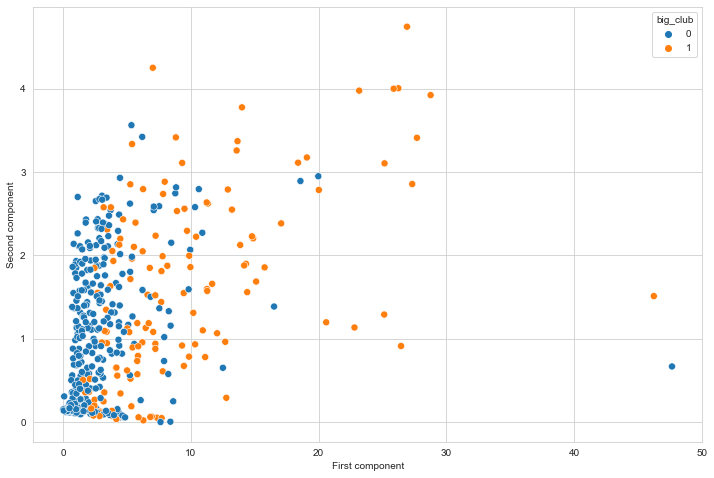

In [34]:
features_NMF_2 = do_NMF(2)

Original number of features: 12
Reduced number of features: 3


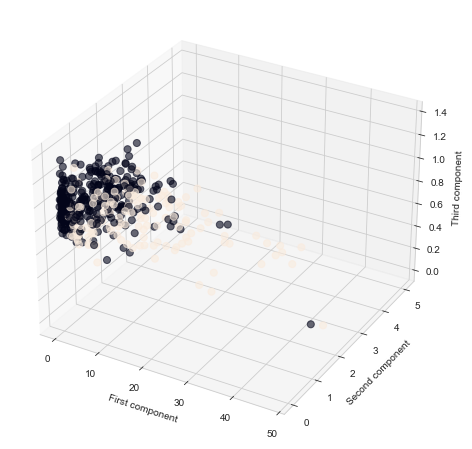

In [35]:
features_NMF_3 = do_NMF(3)

In [36]:
features_NMF_5 = do_NMF(5)

Original number of features: 12
Reduced number of features: 5


In [37]:
features_NMF_5 = do_NMF(8)

Original number of features: 12
Reduced number of features: 8


### Truncated Singular Value Decomposition

In [38]:
def do_TSVD(n_components=8, target='big_club', ss=True, goal_var=0.9):
    features = do_StandardScaling() if ss else dataframe
    if n_components:
        tsvd = TruncatedSVD(n_components=n_components)
        features_tsvd = tsvd.fit_transform(features)
        print(f'Original number of features: {features.shape[1]}')
        print(f'Reduced number of features: {features_tsvd.shape[1]}')
        print(f'Explained variance: {tsvd.explained_variance_ratio_}')
        print(f'Explained variance sum: {round(sum(tsvd.explained_variance_ratio_), 2)}')
        print(f'Explained variance cumulative sum: {np.cumsum(tsvd.explained_variance_ratio_ * 100)}')

        if n_components == 2:
            _show_2d(features_tsvd, target, 'First component', 'Second component')
        elif n_components == 3:
            _show_3d(features_tsvd, target, 'First component', 'Second component', 'Third component')

        return features_tsvd
    else:
        tsvd = TruncatedSVD(n_components=features.shape[1]-1).fit(features)
        tsvd_var_ratios = tsvd.explained_variance_ratio_
        total_variance = 0.0
        n_components = 0
        for explained_variance in tsvd_var_ratios:
            total_variance += explained_variance
            n_components += 1
            if total_variance >= goal_var:
                break
        do_TSVD(n_components, target, ss)

Original number of features: 12
Reduced number of features: 2
Explained variance: [0.29529574 0.17872778]
Explained variance sum: 0.47
Explained variance cumulative sum: [29.52957447 47.40235279]


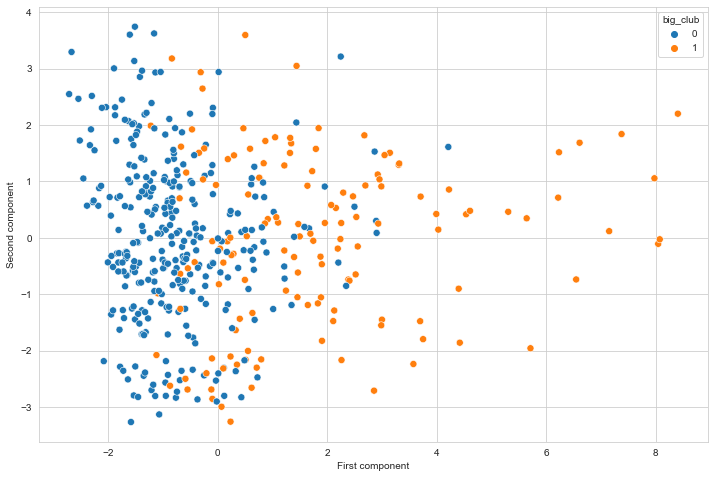

In [39]:
features_TSVD_2 = do_TSVD(2)

Original number of features: 12
Reduced number of features: 3
Explained variance: [0.29529574 0.17872778 0.10919814]
Explained variance sum: 0.58
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667 ]


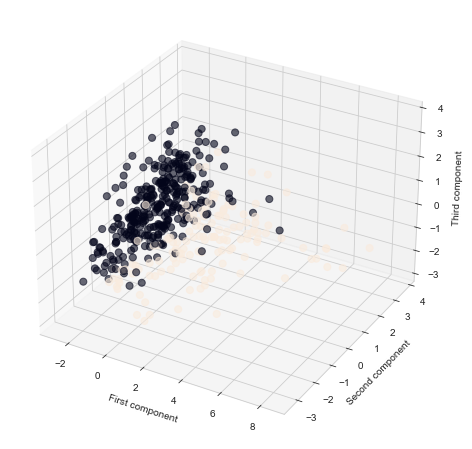

In [40]:
features_TSVD_3 = do_TSVD(3)

In [41]:
features_TSVD_5 = do_TSVD(5)

Original number of features: 12
Reduced number of features: 5
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788 ]
Explained variance sum: 0.76
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329]


In [42]:
features_TSVD_8 = do_TSVD(8)

Original number of features: 12
Reduced number of features: 8
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788  0.07762087
 0.0613634  0.04415543]
Explained variance sum: 0.94
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329 83.74207001
 89.87841032 94.29395378]


In [43]:
features_TSVD_auto_80 = do_TSVD(None, goal_var=0.8)

Original number of features: 12
Reduced number of features: 6
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788  0.07762087]
Explained variance sum: 0.84
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329 83.74207001]


In [44]:
features_TSVD_auto_90 = do_TSVD(None, goal_var=0.9)

Original number of features: 12
Reduced number of features: 8
Explained variance: [0.29529574 0.17872778 0.10919814 0.09309937 0.0834788  0.07762087
 0.0613634  0.04415543]
Explained variance sum: 0.94
Explained variance cumulative sum: [29.52957447 47.40235279 58.3221667  67.63210377 75.97998329 83.74207001
 89.87841032 94.29395378]


## Feature Selection

### Variance Threshold

In [45]:
def do_VarianceThreshold(threshold=.5, ss=False):
    features = do_StandardScaling() if ss else dataframe
    thresholder = VarianceThreshold(threshold=threshold)
    features_high_variance = thresholder.fit_transform(features)
    print(features_high_variance)
    print(f'Feature\'s variances: {thresholder.fit(features).variances_}')
    print(f'Remaining features: {features_high_variance.shape[1]}')
    return features_high_variance

In [46]:
features_VT_10 = do_VarianceThreshold(0.1)

[[28.   1.  65.  ...  1.   1.   0. ]
 [28.   1.  50.  ...  1.   1.   0. ]
 [35.   4.   7.  ...  1.   1.   0. ]
 ...
 [23.   3.   4.5 ... 20.   0.   0. ]
 [21.   1.   1.  ... 20.   0.   1. ]
 [27.   1.  10.  ... 20.   0.   0. ]]
Feature's variances: [1.56625369e+01 9.97953143e-01 1.49918017e+02 8.66378538e+05
 1.80965410e+00 2.81495747e+03 9.21904188e-01 3.35025715e-02
 1.63432320e+00 3.27213781e+01 2.11461456e-01 1.24213607e-01]
Remaining features: 11


In [47]:
features_VT_50 = do_VarianceThreshold()

[[28.   1.  65.  ...  3.   4.   1. ]
 [28.   1.  50.  ...  2.   4.   1. ]
 [35.   4.   7.  ...  2.   6.   1. ]
 ...
 [23.   3.   4.5 ...  1.   2.  20. ]
 [21.   1.   1.  ...  1.   1.  20. ]
 [27.   1.  10.  ...  4.   3.  20. ]]
Feature's variances: [1.56625369e+01 9.97953143e-01 1.49918017e+02 8.66378538e+05
 1.80965410e+00 2.81495747e+03 9.21904188e-01 3.35025715e-02
 1.63432320e+00 3.27213781e+01 2.11461456e-01 1.24213607e-01]
Remaining features: 9


In [48]:
features_VT_ss = do_VarianceThreshold(ss=True)

[[ 0.30200882 -1.18125293  4.40930368 ... -1.63175378  1.51421833
  -0.41237212]
 [ 0.30200882 -1.18125293  3.18422398 ... -1.63175378  1.51421833
  -0.41237212]
 [ 2.07076099  1.82182208 -0.32767117 ... -1.63175378  1.51421833
  -0.41237212]
 ...
 [-0.96138559  0.82079707 -0.53185112 ...  1.68977338 -0.66040675
  -0.41237212]
 [-1.46674336 -1.18125293 -0.81770306 ...  1.68977338 -0.66040675
   2.42499423]
 [ 0.04932993 -1.18125293 -0.08265523 ...  1.68977338 -0.66040675
  -0.41237212]]
Feature's variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Remaining features: 12


In [49]:
features_VT_bin = do_VarianceThreshold((.75 * (1 - .75)))

[[28.   1.  65.  ...  4.   1.   1. ]
 [28.   1.  50.  ...  4.   1.   1. ]
 [35.   4.   7.  ...  6.   1.   1. ]
 ...
 [23.   3.   4.5 ...  2.  20.   0. ]
 [21.   1.   1.  ...  1.  20.   0. ]
 [27.   1.  10.  ...  3.  20.   0. ]]
Feature's variances: [1.56625369e+01 9.97953143e-01 1.49918017e+02 8.66378538e+05
 1.80965410e+00 2.81495747e+03 9.21904188e-01 3.35025715e-02
 1.63432320e+00 3.27213781e+01 2.11461456e-01 1.24213607e-01]
Remaining features: 10


### Select K Best

In [50]:
def do_SelectKBest(k=2, metric=chi2, target='big_club', ss=False):
    features = do_StandardScaling() if ss else dataframe
    selector = SelectKBest(metric, k=k)
    fit = selector.fit(features, dataframe[target])
    features_kbest = selector.fit_transform(features, dataframe[target])   
    if k == 2:
            _show_2d(features_kbest, target, 'First component', 'Second component')
    elif k == 3:
        _show_3d(features_kbest, target, 'First component', 'Second component', 'Third component')

    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_kbest.shape[1]}')
    print(f'Scores: {fit.scores_}')
    return features_kbest

Original number of features: 12
Reduced number of features: 2
Scores: [4.11288078e+00 6.77299085e-02 2.21056619e+03 1.32296240e+05
 2.74717800e+01 1.77588415e+03 2.73900947e-01 2.91597686e+00
 3.04518615e+00 3.53714855e+01 3.21000000e+02 4.96758198e-01]


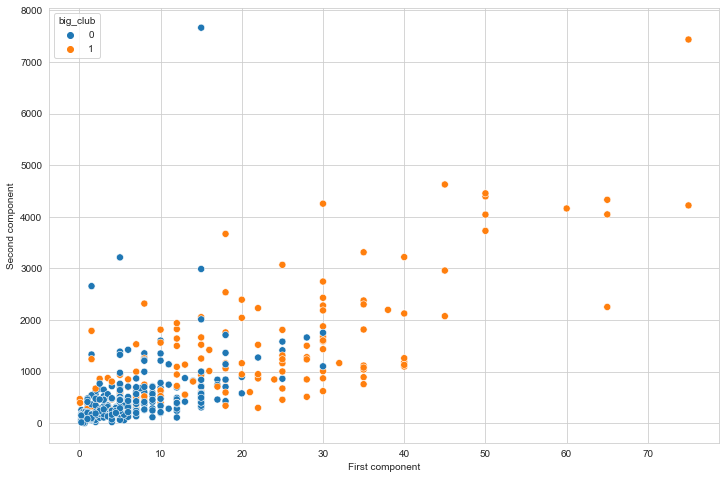

In [51]:
features_SKB_2_chi2 = do_SelectKBest()

Original number of features: 12
Reduced number of features: 3
Scores: [4.11288078e+00 6.77299085e-02 2.21056619e+03 1.32296240e+05
 2.74717800e+01 1.77588415e+03 2.73900947e-01 2.91597686e+00
 3.04518615e+00 3.53714855e+01 3.21000000e+02 4.96758198e-01]


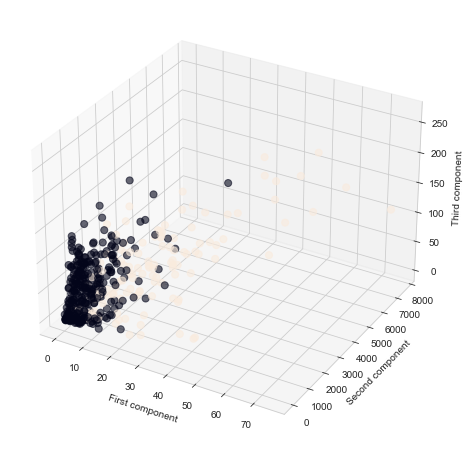

In [52]:
features_SKB_3_chi2 = do_SelectKBest(3)

In [53]:
features_SKB_5_chi2 = do_SelectKBest(5)

Original number of features: 12
Reduced number of features: 5
Scores: [4.11288078e+00 6.77299085e-02 2.21056619e+03 1.32296240e+05
 2.74717800e+01 1.77588415e+03 2.73900947e-01 2.91597686e+00
 3.04518615e+00 3.53714855e+01 3.21000000e+02 4.96758198e-01]


In [54]:
features_SKB_8_chi2 = do_SelectKBest(8)

Original number of features: 12
Reduced number of features: 8
Scores: [4.11288078e+00 6.77299085e-02 2.21056619e+03 1.32296240e+05
 2.74717800e+01 1.77588415e+03 2.73900947e-01 2.91597686e+00
 3.04518615e+00 3.53714855e+01 3.21000000e+02 4.96758198e-01]


Original number of features: 12
Reduced number of features: 2
Scores: [7.11688663e+00 1.47362386e-01 2.49576115e+02 1.55450501e+02
 1.00346853e+02 3.90654712e+01 5.91749295e-01 3.02755428e+00
 6.02595211e+00 1.13987647e+01            inf 5.79441257e-01]


c:\users\bluebell\pycharmprojects\machinelearning\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
c:\users\bluebell\pycharmprojects\machinelearning\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


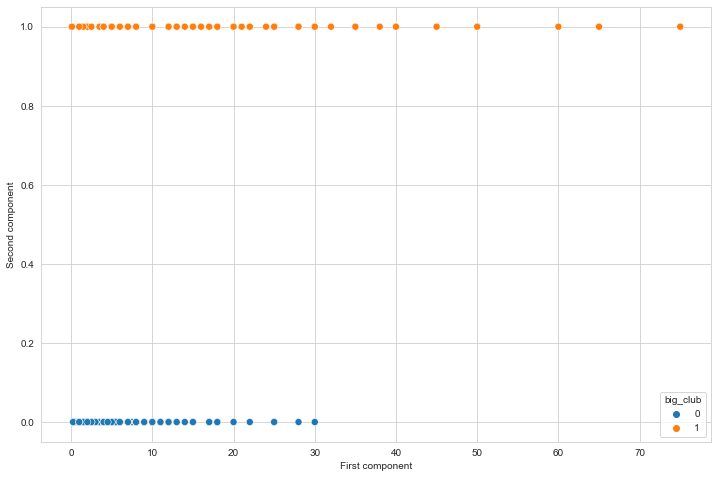

In [55]:
features_SKB_2_fclassif = do_SelectKBest(metric=f_classif)

c:\users\bluebell\pycharmprojects\machinelearning\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
c:\users\bluebell\pycharmprojects\machinelearning\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Original number of features: 12
Reduced number of features: 3
Scores: [7.11688663e+00 1.47362386e-01 2.49576115e+02 1.55450501e+02
 1.00346853e+02 3.90654712e+01 5.91749295e-01 3.02755428e+00
 6.02595211e+00 1.13987647e+01            inf 5.79441257e-01]


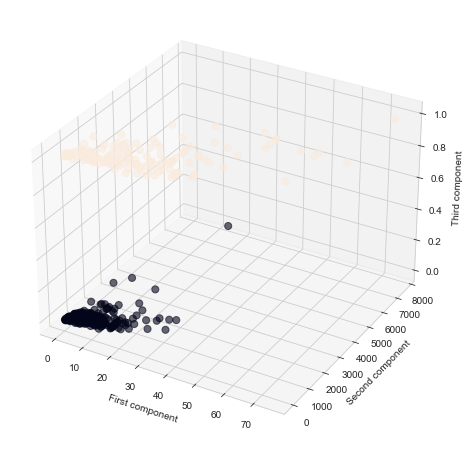

In [56]:
features_SKB_3_fclassif = do_SelectKBest(3, metric=f_classif)

### Select Percentile

In [57]:
def do_SelectPercentile(percentile=75, metric=f_classif, target='big_club', ss=False):
    features = do_StandardScaling() if ss else dataframe
    selector = SelectPercentile(metric, percentile=percentile)
    features_perc = selector.fit_transform(features, dataframe[target])
    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_perc.shape[1]}')
    return features_perc

In [58]:
features_SP_50 = do_SelectPercentile(50, metric=chi2)

Original number of features: 12
Reduced number of features: 6


In [59]:
features_SP_75 = do_SelectPercentile(metric=chi2)

Original number of features: 12
Reduced number of features: 9


In [60]:
features_SP_85 = do_SelectPercentile(85, metric=chi2)

Original number of features: 12
Reduced number of features: 10


In [61]:
features_SP_95 = do_SelectPercentile(95, metric=chi2)

Original number of features: 12
Reduced number of features: 11


### Isomap Embedding

In [62]:
def do_Isomap(n_components=5, ss=False, target='big_club'):
    features = do_StandardScaling() if ss else dataframe
    selector = Isomap(n_components=n_components)
    features_iso = selector.fit_transform(features)
    if n_components == 2:
            _show_2d(features_iso, target, 'First component', 'Second component')
    elif n_components == 3:
        _show_3d(features_iso, target, 'First component', 'Second component', 'Third component')

    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_iso.shape[1]}')
    return features_iso

Original number of features: 12
Reduced number of features: 2


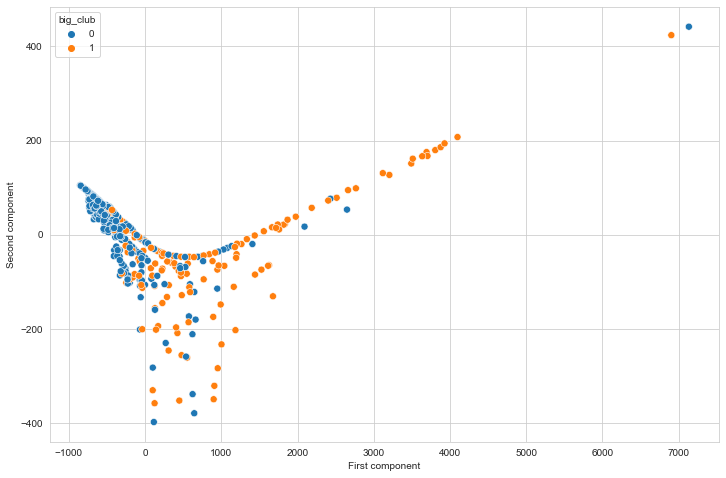

In [63]:
features_ISO_2 = do_Isomap(2)

Original number of features: 12
Reduced number of features: 3


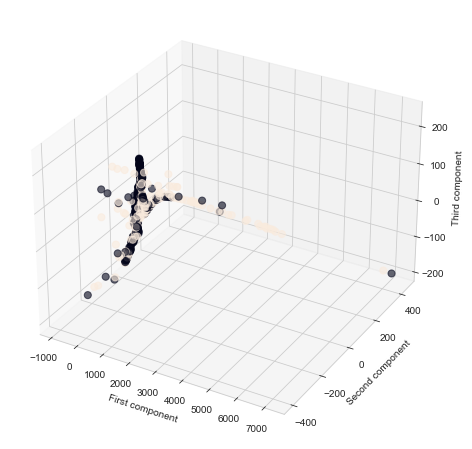

In [64]:
features_ISO_3 = do_Isomap(3)

In [65]:
features_ISO_5 = do_Isomap(5)

Original number of features: 12
Reduced number of features: 5


In [66]:
features_ISO_8 = do_Isomap(8)

Original number of features: 12
Reduced number of features: 8


### Locally Linear Embedding (+ modified)

In [67]:
def do_LLE(n_components=5, modified=False, n_neighbors=5, ss=False, target='big_club'):
    features = do_StandardScaling() if ss else dataframe
    if modified:
        selector = LocallyLinearEmbedding(n_components=n_components, method='modified', n_neighbors=n_neighbors)
    else:
        selector = LocallyLinearEmbedding(n_components=n_components)      
    features_lle = selector.fit_transform(features)
    if n_components == 2:
            _show_2d(features_lle, target, 'First component', 'Second component')
    elif n_components == 3:
        _show_3d(features_lle, target, 'First component', 'Second component', 'Third component')
        
    print(f'Original number of features: {features.shape[1]}')
    print(f'Reduced number of features: {features_lle.shape[1]}')
    return features_lle

Original number of features: 12
Reduced number of features: 2


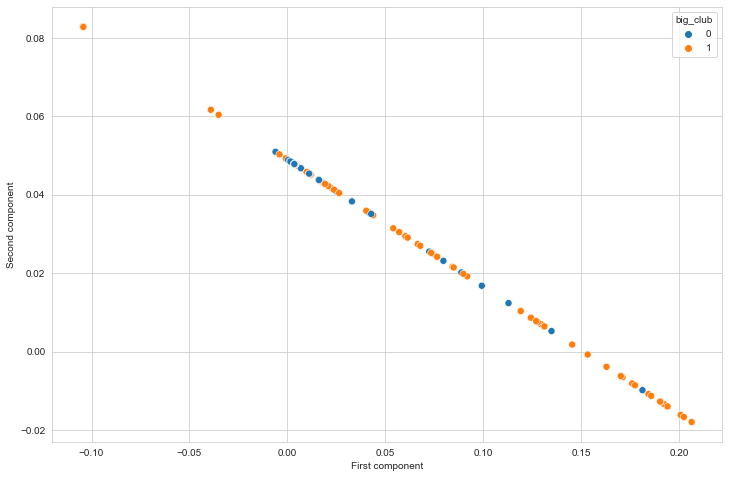

In [68]:
features_LLE_2 = do_LLE(2)

Original number of features: 12
Reduced number of features: 3


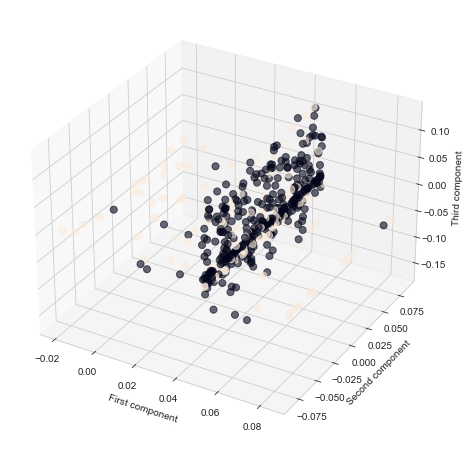

In [69]:
features_LLE_3 = do_LLE(3)

In [70]:
features_LLE_5 = do_LLE(5)

Original number of features: 12
Reduced number of features: 5


In [71]:
features_LLE_8 = do_LLE(8)

Original number of features: 12
Reduced number of features: 8


Original number of features: 12
Reduced number of features: 2


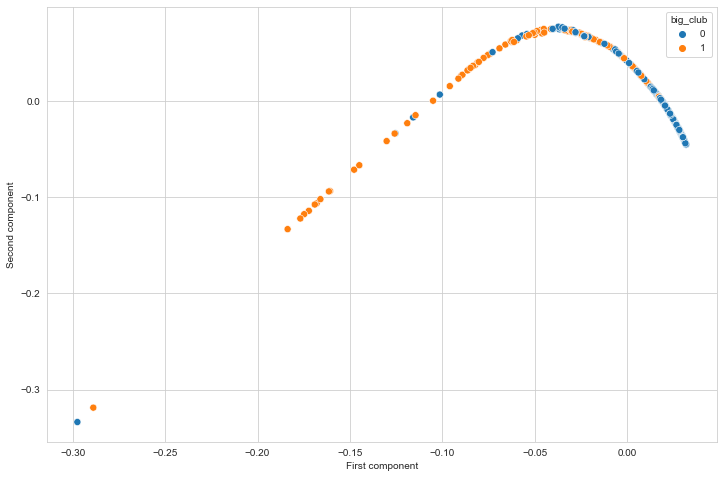

In [72]:
features_LLE_2_mod = do_LLE(2, modified=True)

Original number of features: 12
Reduced number of features: 2


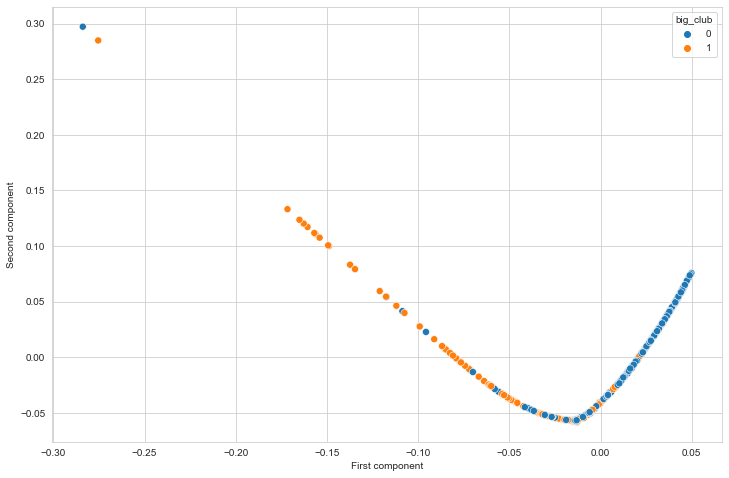

In [73]:
features_LLE_2_mod_10 = do_LLE(2, modified=True, n_neighbors=10)

c:\users\bluebell\pycharmprojects\machinelearning\venv\lib\site-packages\sklearn\manifold\_locally_linear.py:449: RuntimeWarning: invalid value encountered in double_scalars
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


Original number of features: 12
Reduced number of features: 3


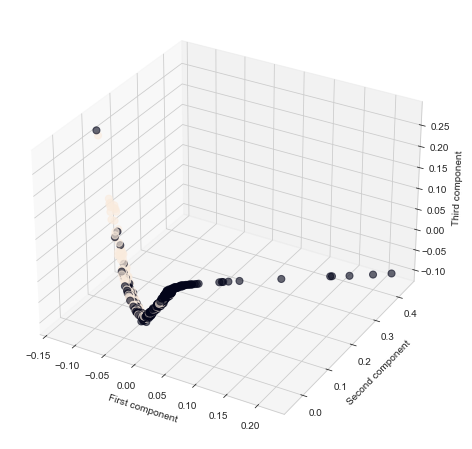

In [74]:
features_LLE_3_mod = do_LLE(3, modified=True)

Original number of features: 12
Reduced number of features: 3


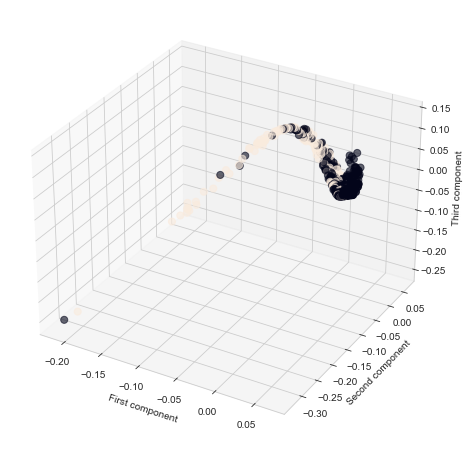

In [75]:
features_LLE_3_mod_10 = do_LLE(3, modified=True, n_neighbors=10)

### Recursive Feature Elimination (Linear Regression / Logistic Regression)

In [76]:
def do_RFE(n_features=3, target='big_club', mtype='logr', ss=True):
    features = do_StandardScaling(target) if ss else dataframe.drop(target, axis=1)
    model = None
    if mtype == 'linr':
        model = LinearRegression(n_jobs=-1)
    elif mtype == 'logr':
        model = LogisticRegression(solver='lbfgs', n_jobs=-1)    
    rfe = RFE(model, n_features_to_select=n_features)
    fit = rfe.fit(features, dataframe[target])
    features_rfe = rfe.transform(features)
    if n_features == 2:
        _show_2d(features_rfe, target, 'First component', 'Second component')
    elif n_features == 3:
        _show_3d(features_rfe, target, 'First component', 'Second component', 'Third component')
        
    print(f'Num Features: {fit.n_features_}')
    print(f'Selected Features: {fit.support_}')
    print(f'Feature Ranking: {fit.ranking_}')
    return features_rfe

Num Features: 2
Selected Features: [False False  True  True False False False False False False False]
Feature Ranking: [ 5  3  1  1 10  2  9  6  8  4  7]


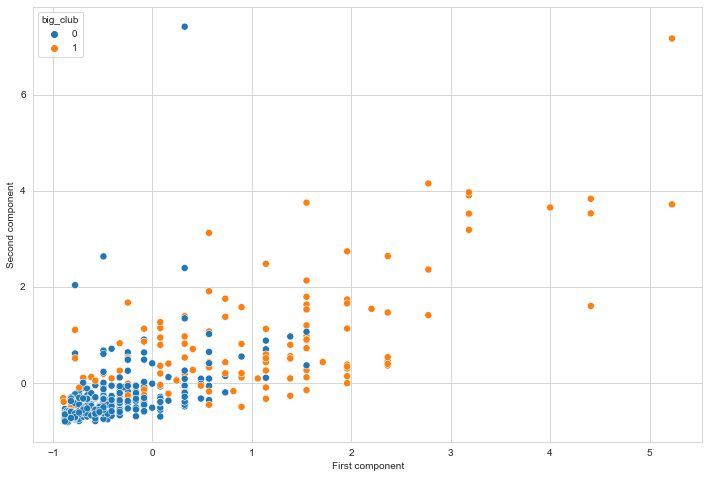

In [77]:
features_RFE_2_logr = do_RFE(2)

Num Features: 2
Selected Features: [False False  True  True False False False False False False False]
Feature Ranking: [ 5  2  1  1  8  3 10  9  6  4  7]


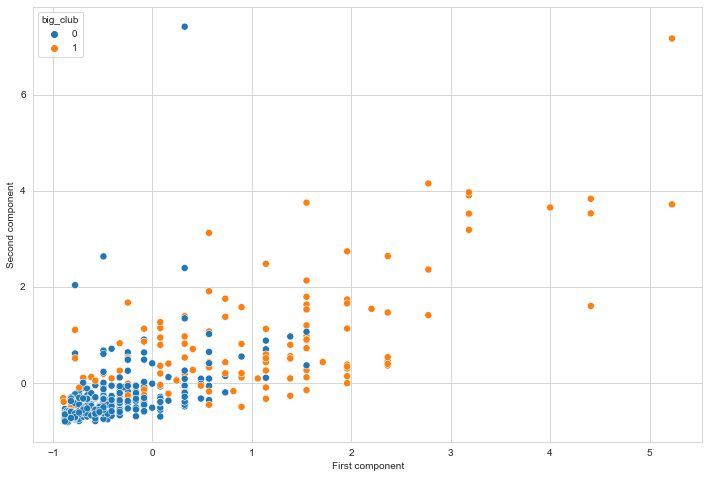

In [78]:
features_RFE_2_linr = do_RFE(2, mtype='linr')

Num Features: 3
Selected Features: [False False  True  True False  True False False False False False]
Feature Ranking: [4 2 1 1 9 1 8 5 7 3 6]


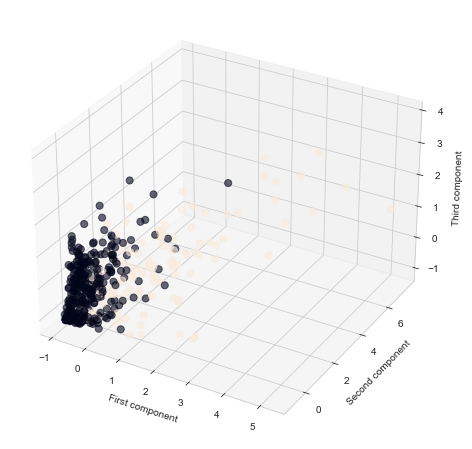

In [79]:
features_RFE_3_logr = do_RFE()

Num Features: 3
Selected Features: [False  True  True  True False False False False False False False]
Feature Ranking: [4 1 1 1 7 2 9 8 5 3 6]


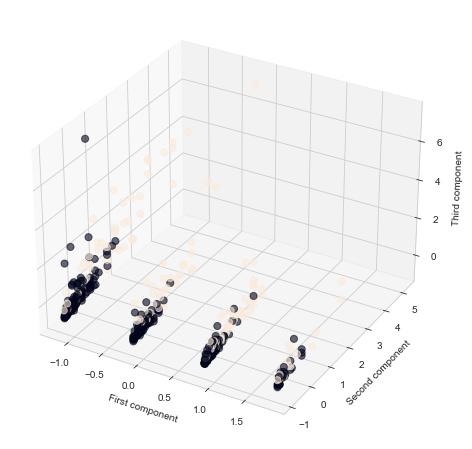

In [80]:
features_RFE_3_linr = do_RFE(mtype='linr')

In [81]:
features_RFE_5_logr = do_RFE(5)

Num Features: 5
Selected Features: [False  True  True  True False  True False False False  True False]
Feature Ranking: [2 1 1 1 7 1 6 3 5 1 4]


In [82]:
features_RFE_5_linr = do_RFE(5, mtype='linr')

Num Features: 5
Selected Features: [False  True  True  True False  True False False False  True False]
Feature Ranking: [2 1 1 1 5 1 7 6 3 1 4]


In [83]:
features_RFE_8_logr = do_RFE(8)

Num Features: 8
Selected Features: [ True  True  True  True False  True False  True False  True  True]
Feature Ranking: [1 1 1 1 4 1 3 1 2 1 1]


In [84]:
features_RFE_8_linr = do_RFE(8, mtype='linr')

Num Features: 8
Selected Features: [ True  True  True  True False  True False False  True  True  True]
Feature Ranking: [1 1 1 1 2 1 4 3 1 1 1]


### RFE (LinR / LogR) with Cross-Validation

In [85]:
def do_RFECV(target='big_club', mtype='linr', ss=True):
    features = do_StandardScaling(target) if ss else dataframe.drop(target, axis=1)
    model = None
    if mtype == 'linr':
        model = LinearRegression(n_jobs=-1)
    elif mtype == 'logr':
        model = LogisticRegression(solver='lbfgs', n_jobs=-1)   
        
    rfecv = RFECV(estimator=model, step=1, scoring='neg_mean_squared_error')
    rfecv.fit(features, dataframe[target])
    features_rfecv = rfecv.transform(features)
    print(f'Number of chosen features: {rfecv.n_features_}')
    print(f'Support vector (chosen features): {rfecv.support_}')
    print(f'Order of feature elimination: {rfecv.ranking_}')
    return features_rfecv

In [86]:
features_RFECV_linr = do_RFECV()

Number of chosen features: 4
Support vector (chosen features): [False  True  True  True False  True False False False False False]
Order of feature elimination: [3 1 1 1 6 1 8 7 4 2 5]


In [87]:
features_RFECV_logr = do_RFECV(mtype='logr')

Number of chosen features: 4
Support vector (chosen features): [False  True  True  True False  True False False False False False]
Order of feature elimination: [3 1 1 1 8 1 7 4 6 2 5]


### ExtraTrees - feature.importances_ selection

In [88]:
def do_ET(n_estimators=10, target='big_club', ss=True, nlargest=5):
    features = do_StandardScaling(target) if ss else dataframe.drop(target, axis=1)
    columns = dataframe.columns.values.tolist()
    columns.remove(target)
    model = ExtraTreesClassifier(n_estimators=n_estimators, n_jobs=-1)
    model.fit(features, dataframe[target])
    print(f'Feature importances: {model.feature_importances_}')
    feat_importances = pd.Series(model.feature_importances_, index=columns)
    feat_importances.nlargest(nlargest).plot(kind='barh')
    plt.tight_layout()
    plt.show()

Feature importances: [0.04937366 0.06836818 0.21781792 0.17998985 0.12920171 0.0892109
 0.04341031 0.00493926 0.04240885 0.15596966 0.01930969]


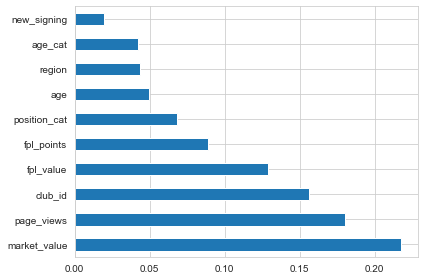

In [89]:
features_ET_10 = do_ET(nlargest=10)

Feature importances: [0.0569755  0.06390554 0.23653555 0.18208959 0.10925176 0.07819351
 0.04088918 0.00752323 0.04192123 0.16575196 0.01696296]


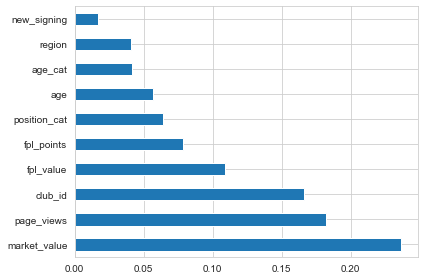

In [90]:
features_ET_100 = do_ET(n_estimators=100, nlargest=10)

### Lasso L1 Regularisation (+ hyperparameter tunning)

In [91]:
def do_Lasso(target='big_club', hyper=False, ss=True):
    features = do_StandardScaling(target) if ss else dataframe.drop(target, axis=1)
    if not hyper:
        selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='saga'))
        selector.fit(features, dataframe[target])
        print(f'Support vectors: {selector.get_support()}')
        selected_feat = dataframe.drop(target, axis=1).columns[(selector.get_support())]

        print(f'Total features: {features.shape[1]}')
        print(f'Selected features: {selected_feat}')
        print(f'Number of selected features: {len(selected_feat)}')
        print(f'Features with coefficients shrank to zero: {np.sum(selector.estimator_.coef_ == 0)}')
        removed_feats = dataframe.drop(target, axis=1).columns[(selector.estimator_.coef_ == 0).ravel().tolist()]
        print(f'Removed features: {removed_feats}')
        features_lasso = selector.transform(features)
        return features_lasso

    else:
        model = Lasso(alpha=1.0)
        cv = RepeatedKFold(n_splits=10, n_repeats=3)
        grid = dict()
        grid['alpha'] = np.arange(0, 1, 0.01)
        search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
        results = search.fit(features, dataframe[target])
        print(f'MAE: {results.best_score_:.3f}')
        print(f'Config: {results.best_params_}')
        features_lasso = results.transform(features)
        return features_lasso

In [92]:
features_Lasso = do_Lasso()

Support vectors: [ True  True  True  True False  True  True  True False  True  True]
Total features: 11
Selected features: Index(['age', 'position_cat', 'market_value', 'page_views', 'fpl_points',
       'region', 'new_foreign', 'club_id', 'new_signing'],
      dtype='object')
Number of selected features: 9
Features with coefficients shrank to zero: 2
Removed features: Index(['fpl_value', 'age_cat'], dtype='object')


In [93]:
features_Lasso_hyper = do_Lasso()

Support vectors: [ True  True  True  True False  True  True  True False  True  True]
Total features: 11
Selected features: Index(['age', 'position_cat', 'market_value', 'page_views', 'fpl_points',
       'region', 'new_foreign', 'club_id', 'new_signing'],
      dtype='object')
Number of selected features: 9
Features with coefficients shrank to zero: 2
Removed features: Index(['fpl_value', 'age_cat'], dtype='object')


## Clustering

### K-Means

In [94]:
def do_KMeans(feat=None, n_clusters=3, init='k-means++', n_init=10, metric='elbow'):
    if feat == 'pca2':
        features = features_PCA_2
    elif feat == 'pca3':
        features = features_PCA_3
    elif feat == 'skb2':
        features = features_SKB_2_chi2
    elif feat == 'skb3':
        features = features_SKB_3_chi2
    else:
        features = do_StandardScaling()

    if not n_clusters:
        if metric == 'elbow':
            sse = []
            for k in range(1, 11):
                kmeans = KMeans(n_clusters=k, init=init, n_init=n_init)
                kmeans.fit(features)
                sse.append(kmeans.inertia_)
            plt.style.use('fivethirtyeight')
            plt.plot(range(1, 11), sse)
            plt.xticks(range(1, 11))
            plt.xlabel('Number of Clusters')
            plt.ylabel('SSE')
            kl = KneeLocator(range(1, 11), sse, curve='convex', direction='decreasing')
            print(f'Best number of clusters (elbow function): {kl.elbow}')
            do_KMeans(feat, kl.elbow, init, n_init)

        elif metric == 'silhouette':
            silhouette_coefficients = []
            for k in range(2, 11):
                kmeans = KMeans(n_clusters=k, init=init, n_init=n_init)
                kmeans.fit(features)
                score = silhouette_score(features, kmeans.labels_)
                silhouette_coefficients.append(score)
            plt.style.use('fivethirtyeight')
            plt.plot(range(2, 11), silhouette_coefficients)
            plt.xticks(range(2, 11))
            plt.xlabel('Number of Clusters')
            plt.ylabel('Silhouette Coefficient')
            best = int(np.amax(silhouette_coefficients))
            do_KMeans(feat, best, init, n_init)

        else:
            ari_scores = []
            for k in range(2, 11):
                kmeans = KMeans(n_clusters=k, init=init, n_init=n_init)
                kmeans.fit(features)
                score = adjusted_rand_score(features, kmeans.labels_)
                ari_scores.append(score)
            plt.figure(figsize=(15, 8))
            plt.style.use('fivethirtyeight')
            plt.plot(range(2, 11), ari_scores)
            plt.xticks(range(2, 11))
            plt.xlabel('Number of Clusters')
            plt.ylabel('Silhouette Coefficient')
            best = int(np.amax(ari_scores))
            do_KMeans(feat, best, init, n_init)

    else:
        cluster = KMeans(n_clusters=n_clusters, init=init, n_init=n_init)
        model = cluster.fit(features)
        features_kmeans = cluster.transform(features)
        if n_clusters == 2:
            fte_colors = {0: "#008fd5", 1: "#fc4f30"}
            km_colors = [fte_colors[label] for label in model.labels_]
            plt.scatter(features_kmeans[:, 0], features_kmeans[:, 1], c=km_colors)
        elif n_clusters == 3:
            fig = plt.figure(figsize=(15, 8))
            fte_colors = {0: "#008fd5", 1: "#fc4f30", 2:'#dead69'}
            km_colors = [fte_colors[label] for label in model.labels_]
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(features_kmeans[:, 0], features_kmeans[:, 1], features_kmeans[:, 2], c=km_colors)
        print(f'Model labels: {model.labels_}')
        print(f'Cluster centers: {model.cluster_centers_}')
        print(f'Model inertia: {model.inertia_}')
        print(f'Model iterations: {model.n_iter_}')
        print(f'Silhouette score: {silhouette_score(features, model.labels_)}')

        return model

Model labels: [1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[ 0.03487147  0.1225344  -0.3811

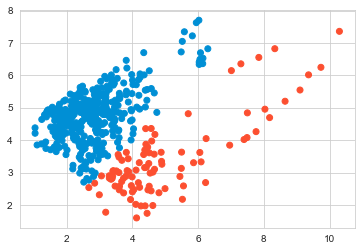

In [95]:
model_KMeans_2 = do_KMeans(n_clusters=2)

Model labels: [2 2 1 2 2 2 2 1 2 2 2 2 2 2 0 0 0 1 2 0 0 2 0 1 0 1 0 2 2 2 1 1 0 0 0 0 1
 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0
 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 0 1 0
 0 2 2 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 2 1 1 1 1 0 1 0 1 0 2 0 1 1 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 2 2 1 1 0 1 1 2 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 2 2 2 2 2 2 2 1 1
 0 2 2 2 2 1 1 0 0 0 0 0 0 0 0 2 0 0 2 2 2 2 2 2 2 1 1 1 1 2 2 1 2 2 1 0 0
 2 2 2 1 2 2 2 2 2 2 2 2 2 0 2 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 2 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0
 0 1 0 1 0 0 2 2 2 2 1 2 2 2 2 0 2 1 2 0 2 0 2 1 0 0 1 1 1 1 1 1 1 1 0 0 1
 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 2 1 1
 2 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0]
Cluster centers: [[-0.67771779 -0.0527389  -0.3279

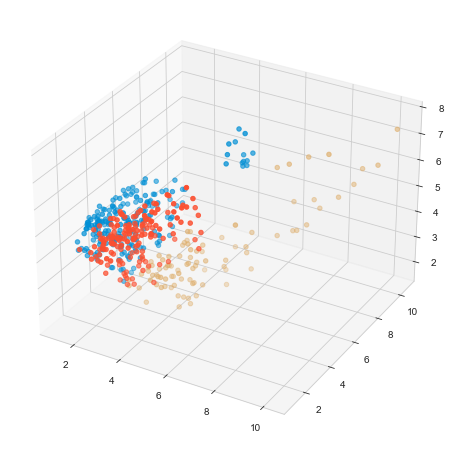

In [96]:
model_KMeans_3 = do_KMeans(n_clusters=3)

Best number of clusters (elbow function): 4
Model labels: [0 0 2 0 0 0 0 2 0 0 0 0 0 0 1 1 1 2 0 1 1 0 1 2 1 2 3 3 0 0 2 2 1 1 1 1 2
 1 1 2 1 1 1 2 1 1 1 2 2 1 1 2 2 1 1 1 2 2 2 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1
 2 1 1 1 2 2 1 1 2 2 2 2 1 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 2 3
 3 0 0 1 1 2 2 2 2 1 2 2 2 1 1 1 2 1 2 1 1 2 0 2 2 2 2 1 2 1 2 1 0 1 2 2 1
 1 1 1 1 1 2 1 1 1 1 1 3 3 1 2 1 2 1 1 2 1 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 0 0 2 2 1 2 2 0 1 1 2 2 1 1 1 2 1 2 2 1 1 2 1 3 0 0 0 0 0 0 0 2 2
 1 0 0 0 0 2 2 1 1 1 1 1 1 1 1 3 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 2 0 0 2 1 3
 3 0 0 2 0 0 0 0 0 0 2 0 0 1 0 1 1 2 1 2 2 2 1 1 1 3 2 1 1 1 1 1 1 2 1 1 1
 1 2 1 1 1 1 1 1 1 2 2 1 2 2 1 1 1 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 3 1 2 2 2
 2 2 1 2 2 2 2 2 2 1 1 1 2 1 1 1 2 1 0 2 2 1 1 2 2 2 2 1 2 1 1 2 1 2 1 1 1
 1 2 1 2 3 1 0 0 0 0 2 2 0 0 1 1 0 2 0 1 1 1 0 2 1 1 2 2 2 2 2 2 2 2 1 1 2
 1 1 1 1 2 1 2 1 2 2 3 1 3 2 1 1 2 1 2 2 2 2 1 2 1 2 2 1 1 1 2 3 2 1 0 2 2
 1 2 2 2 2 2 2 1 1 1 2 2 1 1 1 1 1]
Cluste

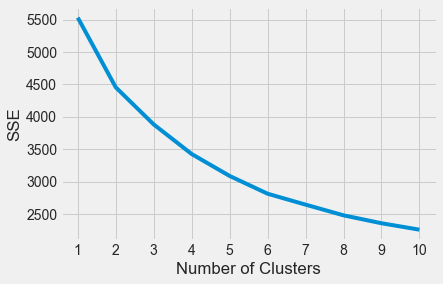

In [97]:
model_KMeans_auto_elbow = do_KMeans(n_clusters=None)

Best number of clusters (elbow function): 4
Model labels: [2 2 3 2 2 2 2 3 2 2 2 2 2 2 0 0 0 3 2 0 0 2 0 3 0 3 1 1 2 2 3 3 0 0 0 0 3
 0 0 3 0 0 0 3 0 0 0 3 3 0 0 3 3 0 0 0 3 3 3 3 0 3 0 0 3 3 0 0 0 0 0 3 3 0
 3 0 0 0 3 3 0 0 3 3 3 3 0 0 0 0 0 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 0 0 3 1
 1 2 2 0 0 3 3 3 3 0 3 3 3 0 0 0 3 0 3 0 0 3 2 3 3 3 3 0 3 0 3 0 2 0 3 3 0
 0 3 0 0 0 3 0 0 0 0 0 1 1 0 3 0 3 0 0 3 0 3 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0
 0 0 0 0 2 2 3 3 0 3 3 2 0 0 3 3 0 0 0 3 0 3 3 0 0 3 0 1 2 2 2 2 2 2 2 3 3
 0 2 2 2 2 3 3 0 0 0 0 0 0 0 0 1 0 0 2 2 2 2 2 2 3 3 3 3 3 2 2 3 2 2 3 0 1
 1 2 2 3 2 2 2 2 2 2 3 2 2 0 2 0 0 3 0 3 3 3 0 0 0 1 3 0 0 0 0 0 0 3 0 0 0
 0 3 0 0 3 0 0 0 0 3 3 0 0 3 0 0 0 3 3 0 3 0 3 0 0 0 0 0 0 0 3 0 1 0 3 3 3
 3 3 0 3 3 3 3 3 3 0 0 0 3 0 0 0 3 0 2 3 3 0 0 3 3 3 3 0 3 0 0 3 0 3 0 0 0
 0 3 0 3 1 0 2 2 2 2 3 3 2 2 0 0 2 3 2 0 0 0 2 3 0 0 3 3 3 3 3 3 3 3 0 0 3
 0 0 0 0 3 0 3 0 3 3 1 0 1 3 0 0 3 0 0 3 3 3 0 3 0 3 3 3 0 0 3 1 3 0 2 3 3
 0 3 3 3 3 3 3 0 0 0 3 3 0 0 0 0 0]
Cluste

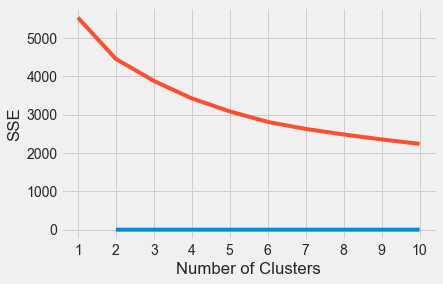

In [98]:
model_KMeans_auto_silhouette = do_KMeans(n_clusters=None, metric='silhouette')

Model labels: [0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0
 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1
 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0
 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1]
Cluster centers: [[ 0.14477549  0.76479296]
 [-0.1

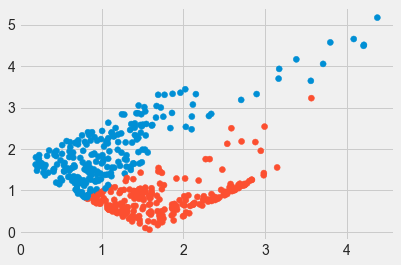

In [99]:
model_KMeans_PCA_2 = do_KMeans(feat='pca2', n_clusters=2, metric='silhouette')

Model labels: [2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 0 0 2 2 0 0 2 0 0 0 0 0 2 2 2 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0
 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 0 1 0
 0 2 2 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 2 1 1 1 1 0 1 0 0 1 2 1 1 1 0
 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 2 2 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 1 1 0 0 0 0 0 0 0 0 2 0 0 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 1 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 2 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0 1 0 0 2 2 2 2 2 2 2 1 0 0 2 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Cluster centers: [[-0.4264916  -0.72790672 -0.5424

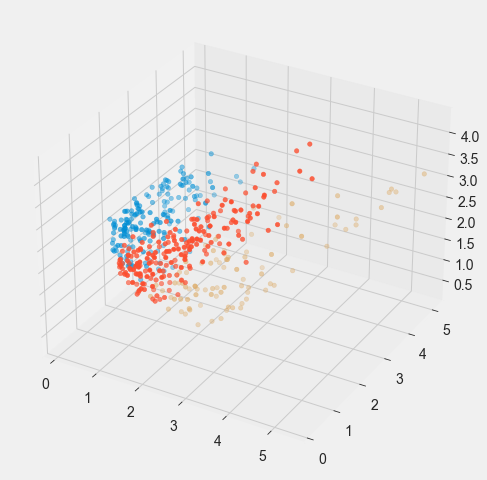

In [100]:
model_KMeans_PCA_3 = do_KMeans(feat='pca3', n_clusters=3, metric='silhouette')

Model labels: [1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[   8.8748227   541.77541371]
 [

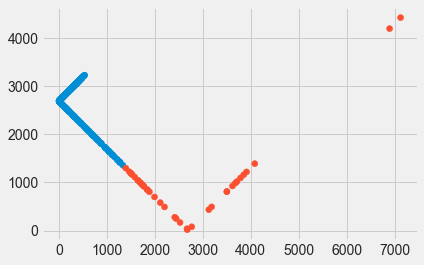

In [101]:
model_KMeans_SKB_2 = do_KMeans(feat='skb2', n_clusters=2, metric='silhouette')

Model labels: [2 2 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 1 0 0 0 0 0 0 1 2 1 0 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 2 1 1 0 0
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 0 0 1 1 1
 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 2 0 0 0 0 1 1 0 1 1 2 0 1 0 0 1 1 1
 0 2 0 0 2 0 0 1 0 0 0 2 2 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 2 2 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Cluster centers: [[  21.03370787 1551.20224719   8

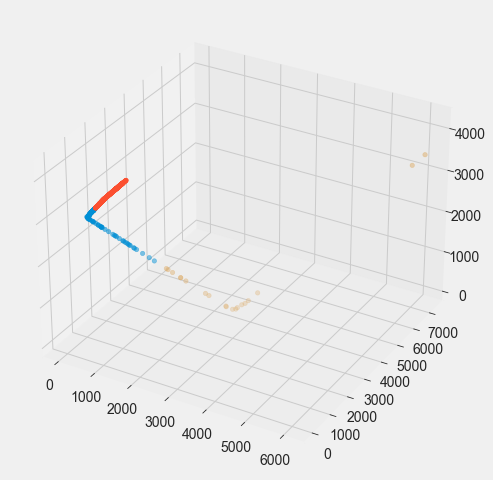

In [102]:
model_KMeans_SKB_3 = do_KMeans(feat='skb3', n_clusters=3, metric='silhouette')

### Mini Batch K-Means

In [103]:
def do_MiniBatchKMeans(feat=None, n_clusters=3, batch_size=100):
    if feat:
        features = feat
    else:
        features = do_StandardScaling()
    cluster = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    model = cluster.fit(features)
    features_mbkmeans = cluster.transform(features)
    if n_clusters == 2:
            fte_colors = {0: "#008fd5", 1: "#fc4f30"}
            km_colors = [fte_colors[label] for label in model.labels_]
            plt.scatter(features_mbkmeans[:, 0], features_mbkmeans[:, 1], c=km_colors)
    elif n_clusters == 3:
        fig = plt.figure(figsize=(15, 8))
        fte_colors = {0: "#008fd5", 1: "#fc4f30", 2:'#dead69'}
        km_colors = [fte_colors[label] for label in model.labels_]
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(features_mbkmeans[:, 0], features_mbkmeans[:, 1], features_mbkmeans[:, 2], c=km_colors)
    print(f'Model labels: {model.labels_}')
    print(f'Cluster centers: {model.cluster_centers_}')
    print(f'Model inertia: {model.inertia_}')
    print(f'Model iterations: {model.n_iter_}')
    print(f'Silhouette score: {silhouette_score(features, model.labels_)}')
    return model

Model labels: [0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Cluster centers: [[-0.17013777 -0.53831817  1.6095

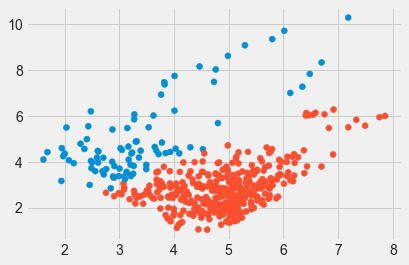

In [104]:
model_MBKM_2 = do_MiniBatchKMeans(n_clusters=2)

Model labels: [2 2 0 2 2 2 2 0 2 2 2 2 2 2 1 1 1 0 2 1 1 2 1 1 1 0 1 2 2 2 0 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 1 1 0 1
 1 2 2 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 2 0 0 0 0 1 0 1 1 0 2 1 0 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 2 2 0 0 1 0 0 2 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 2 2 2 2 2 2 2 0 0
 1 2 2 2 2 0 0 1 1 1 1 1 1 1 1 2 1 1 2 2 2 2 2 2 0 0 0 0 0 2 2 0 2 2 0 1 1
 2 2 2 0 2 2 2 0 2 2 0 2 2 0 2 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 2 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1
 1 0 1 0 1 1 2 2 2 2 0 0 2 2 2 1 2 0 2 1 0 1 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 2 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0]
Cluster centers: [[ 0.88051047  0.29394181 -0.2932

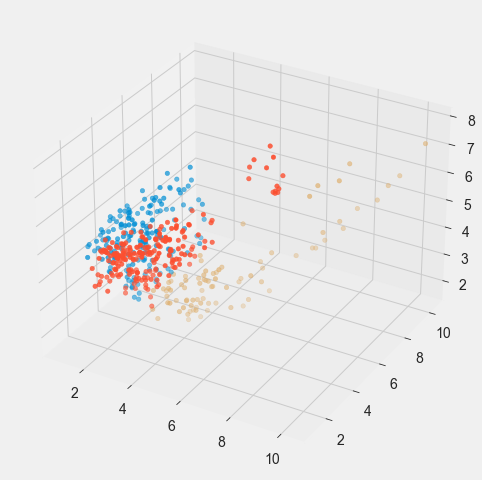

In [105]:
model_MBKM_3 = do_MiniBatchKMeans(n_clusters=3)

### Gaussian Mixture

In [106]:
def do_GaussianMixture(feat=None, n_components=1):
    if feat == 'pca2':
        features = features_PCA_2
    elif feat == 'pca3':
        features = features_PCA_3
    elif feat == 'skb2':
        features = features_SKB_2_chi2
    elif feat == 'skb3':
        features = features_SKB_3_chi2
    else:
        features = do_StandardScaling()
    cluster = GaussianMixture(n_components=n_components)
    model = cluster.fit(features)
    proba = cluster.predict_proba(features)
    print(f'Model iterations: {model.n_iter_}')
    print(f'Probabilities:\n {proba[:10]}')
    return model

In [107]:
model_GM_1 = do_GaussianMixture()

Model iterations: 2
Probabilities:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [108]:
model_GM_2 = do_GaussianMixture(n_components=2)

Model iterations: 13
Probabilities:
 [[1.00000000e+00 1.77429139e-90]
 [1.00000000e+00 9.28311954e-94]
 [1.00000000e+00 1.74615289e-28]
 [1.00000000e+00 2.41232839e-38]
 [1.00000000e+00 2.49832699e-19]
 [1.00000000e+00 7.36812457e-24]
 [1.00000000e+00 7.68105730e-37]
 [1.00000000e+00 2.19251341e-20]
 [1.00000000e+00 3.74984209e-26]
 [1.00000000e+00 7.66569583e-31]]


In [109]:
model_GM_3 = do_GaussianMixture(n_components=3)

Model iterations: 10
Probabilities:
 [[7.65748391e-13 1.00000000e+00 0.00000000e+00]
 [1.71619618e-09 9.99999998e-01 0.00000000e+00]
 [1.00000000e+00 7.71480600e-89 0.00000000e+00]
 [9.99999008e-01 9.92186162e-07 0.00000000e+00]
 [1.00000000e+00 1.34820782e-48 0.00000000e+00]
 [1.00000000e+00 2.77232675e-50 0.00000000e+00]
 [1.00000000e+00 1.69548707e-12 0.00000000e+00]
 [1.00000000e+00 1.02439373e-50 0.00000000e+00]
 [1.00000000e+00 3.20343940e-27 0.00000000e+00]
 [1.00000000e+00 1.67296316e-26 0.00000000e+00]]


In [110]:
model_GM_5 = do_GaussianMixture(n_components=5)

Model iterations: 9
Probabilities:
 [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [111]:
model_GM_8 = do_GaussianMixture(n_components=8)

Model iterations: 10
Probabilities:
 [[0.00000000e+000 6.57791791e-006 0.00000000e+000 9.99993422e-001
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.56382261e-003 0.00000000e+000 9.98436177e-001
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.05952051e-010 0.00000000e+000 0.00000000e+000
  1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 9.49515604e-048
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 2.33094666e-123
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 2.20451790e-105
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+00

In [112]:
model_GM_PCA_2 = do_GaussianMixture(feat='pca2', n_components=2)

Model iterations: 14
Probabilities:
 [[1.00000000e+00 1.07919490e-36]
 [1.00000000e+00 7.95928718e-22]
 [7.45031749e-01 2.54968251e-01]
 [9.99999278e-01 7.21777212e-07]
 [9.89518912e-01 1.04810882e-02]
 [9.99690630e-01 3.09370020e-04]
 [9.99999960e-01 4.03532339e-08]
 [7.92982614e-01 2.07017386e-01]
 [9.99692998e-01 3.07001567e-04]
 [9.80550695e-01 1.94493054e-02]]


In [113]:
model_GM_PCA_3 = do_GaussianMixture(feat='pca3', n_components=3)

Model iterations: 34
Probabilities:
 [[1.14378852e-58 3.70196957e-06 9.99996298e-01]
 [2.68362373e-36 4.76183744e-03 9.95238163e-01]
 [8.97316540e-05 9.99894219e-01 1.60491168e-05]
 [9.37018623e-13 9.79660835e-01 2.03391651e-02]
 [1.92258480e-06 9.99554185e-01 4.43892139e-04]
 [3.43668532e-09 9.99192859e-01 8.07137121e-04]
 [6.40410439e-14 9.00347171e-01 9.96528286e-02]
 [5.62756673e-04 9.99323299e-01 1.13944093e-04]
 [7.66052337e-07 8.97176039e-01 1.02823195e-01]
 [1.46825093e-04 9.77110425e-01 2.27427503e-02]]


In [114]:
model_GM_SKB_2 = do_GaussianMixture(feat='skb2', n_components=2)

Model iterations: 12
Probabilities:
 [[5.07674227e-75 1.00000000e+00]
 [1.41316458e-75 1.00000000e+00]
 [2.90503492e-08 9.99999971e-01]
 [1.77827640e-20 1.00000000e+00]
 [2.57575171e-02 9.74242483e-01]
 [8.10360906e-09 9.99999992e-01]
 [2.06489681e-16 1.00000000e+00]
 [9.31217349e-01 6.87826506e-02]
 [6.84211248e-11 1.00000000e+00]
 [5.13952669e-12 1.00000000e+00]]


In [115]:
model_GM_SKB_3 = do_GaussianMixture(feat='skb3', n_components=3)

Model iterations: 15
Probabilities:
 [[1.33603650e-009 1.69963927e-124 9.99999999e-001]
 [8.54167584e-009 3.72427668e-122 9.99999991e-001]
 [9.16948403e-001 2.44340736e-012 8.30515975e-002]
 [4.94341595e-001 3.86254312e-030 5.05658405e-001]
 [9.84488164e-001 3.05931320e-005 1.54812429e-002]
 [9.49213007e-001 1.48704256e-016 5.07869935e-002]
 [7.34709155e-001 4.30236663e-025 2.65290845e-001]
 [3.77495025e-001 6.16626283e-001 5.87869221e-003]
 [9.53662995e-001 1.43749394e-020 4.63370048e-002]
 [9.29564979e-001 1.38466659e-017 7.04350209e-002]]


### Gaussian Hidden Markov Model

In [116]:
def do_GaussianHMM(feat=None, n_components=1):
    if feat:
        features = feat
    else:
        features = do_StandardScaling()
    cluster = hmm.GaussianHMM(n_components=n_components)
    model = cluster.fit(features)
    proba = cluster.predict_proba(features)
    print(f'Probabilities: {proba[:10]}')
    return model

In [117]:
model_GHMM_1 = do_GaussianHMM()

Probabilities: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [118]:
model_GHMM_2 = do_GaussianHMM(n_components=2)

Probabilities: [[0.00000000e+00 1.00000000e+00]
 [4.64239141e-54 1.00000000e+00]
 [9.41804314e-01 5.81956858e-02]
 [5.12545052e-10 9.99999999e-01]
 [1.48035629e-01 8.51964371e-01]
 [2.30999914e-06 9.99997690e-01]
 [7.18702507e-13 1.00000000e+00]
 [9.91055505e-01 8.94449544e-03]
 [2.93566749e-06 9.99997064e-01]
 [1.05339654e-02 9.89466035e-01]]


In [119]:
model_GHMM_3 = do_GaussianHMM(n_components=3)

Probabilities: [[0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [2.29174236e-95 1.00000000e+00 0.00000000e+00]
 [1.54630577e-08 9.99999985e-01 0.00000000e+00]
 [1.74957133e-25 1.00000000e+00 0.00000000e+00]
 [7.29045641e-10 9.99999999e-01 0.00000000e+00]
 [1.07301120e-18 1.00000000e+00 0.00000000e+00]
 [6.17444068e-28 1.00000000e+00 0.00000000e+00]
 [2.41960649e-05 9.99975804e-01 0.00000000e+00]
 [3.52793533e-20 1.00000000e+00 0.00000000e+00]
 [1.78052915e-11 1.00000000e+00 0.00000000e+00]]


In [120]:
model_GHMM_5 = do_GaussianHMM(n_components=5)

Probabilities: [[0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [8.32279980e-022 3.55167295e-120 1.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [9.99995643e-001 3.05517279e-012 4.35727917e-006 0.00000000e+000
  0.00000000e+000]
 [2.03406501e-001 4.79395329e-027 7.96593499e-001 0.00000000e+000
  0.00000000e+000]
 [9.99394056e-001 9.11401738e-015 6.05944431e-004 0.00000000e+000
  0.00000000e+000]
 [5.39276843e-001 1.42023197e-022 4.60723157e-001 0.00000000e+000
  0.00000000e+000]
 [9.62873058e-003 3.55360548e-032 9.90371269e-001 0.00000000e+000
  0.00000000e+000]
 [9.99910962e-001 2.78745606e-008 8.90096644e-005 0.00000000e+000
  0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 9.97732326e-001 0.00000000e+000
  2.26767437e-003]
 [2.25731437e-001 4.91024084e-009 7.74268558e-001 0.00000000e+000
  0.00000000e+000]]


In [121]:
model_GHMM_8 = do_GaussianHMM(n_components=8)

Probabilities: [[0.00000000e+000 0.00000000e+000 7.38789416e-161 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.51475272e-005 2.40128378e-295
  0.00000000e+000 0.00000000e+000 0.00000000e+000 9.99964852e-001]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 8.01089314e-135
  1.31115935e-023 0.00000000e+000 0.00000000e+000 6.76577427e-016]
 [0.00000000e+000 0.00000000e+000 9.99999529e-001 4.34370502e-117
  0.00000000e+000 0.00000000e+000 0.00000000e+000 4.70883249e-007]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 8.08842704e-106
  0.00000000e+000 0.00000000e+000 0.00000000e+000 3.09570230e-012]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 6.13704048e-104
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.81905964e-010]
 [0.00000000e+000 0.00000000e+000 9.99997936e-001 2.31183522e-116
  0.00000000e+000 0.00000000e+000 0.00000000e+000 2.06366922e-006]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 1.47

### Agglomerative Clustering (Hierarchical Clustering)

In [122]:
def do_AgglomerativeClustering(feat=None, n_clusters=3, linkage='ward'):
    if feat == 'pca2':
        features = features_PCA_2
    elif feat == 'pca3':
        features = features_PCA_3
    elif feat == 'skb2':
        features = features_SKB_2_chi2
    elif feat == 'skb3':
        features = features_SKB_3_chi2
    else:
        features = do_StandardScaling()

    plt.figure(figsize=(12, 8))
    plt.title('Dendograms')
    dend = sch.dendrogram(sch.linkage(features, method=linkage), orientation='top',
                          distance_sort='descending', show_leaf_counts=True)

    cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    model = cluster.fit(features)
    features_ac = cluster.fit_predict(features)
    print(f'Model labels: {model.labels_}')
    print(f'Silhouette score: {silhouette_score(features, model.labels_)}')
    if n_clusters == 2:
        plt.figure()
        fte_colors = {0: "#008fd5", 1: "#fc4f30"}
        km_colors = [fte_colors[label] for label in model.labels_]
        plt.scatter(features[:, 0], features[:, 1], c=km_colors)
    elif n_clusters == 3:
        fig = plt.figure(figsize=(15, 8))
        fte_colors = {0: "#008fd5", 1: "#fc4f30", 2:'#dead69'}
        km_colors = [fte_colors[label] for label in model.labels_]
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=km_colors)
        

    return model

Model labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1
 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1]
Silhouette score: 0.18044480041344535


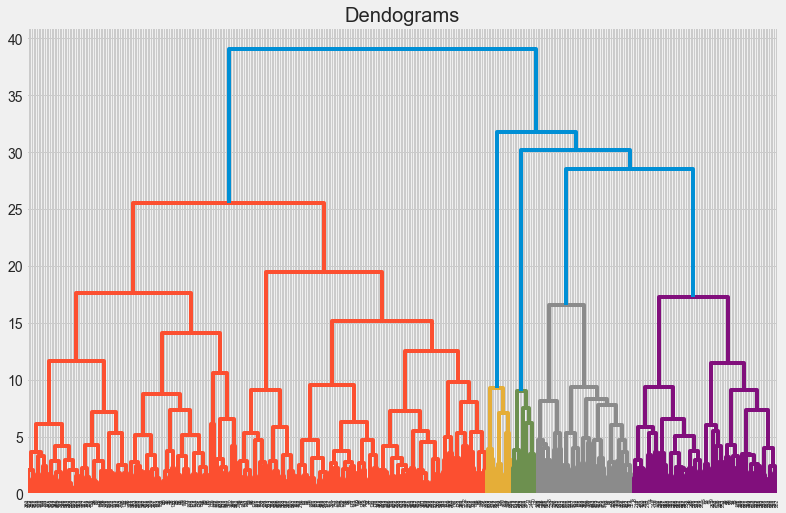

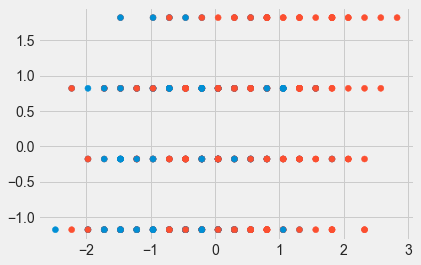

In [123]:
model_AC_2 = do_AgglomerativeClustering(n_clusters=2)

Model labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 2
 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 0 1 1 1 0 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 2 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1
 0 0 1 0 1 0 0 1 1 1 2 1 2 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 2 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1]
Silhouette score: 0.19674019515044563


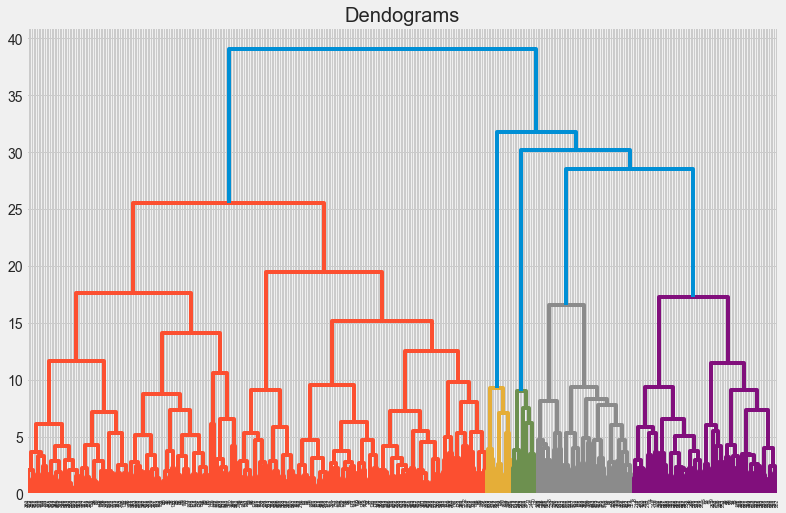

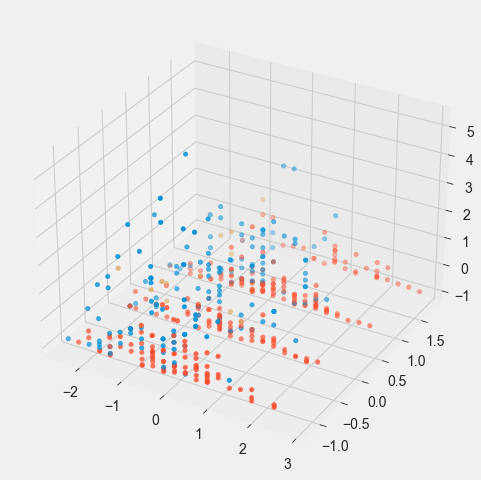

In [124]:
model_AC_3 = do_AgglomerativeClustering()

Model labels: [3 3 0 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 0 4 0 0 4 0 0 0 0 0 3 3 1 4 1 1 1 1 1 1 1 1 4 0 4 1 1 0 2
 2 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0
 0 4 4 0 0 0 4 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 4 0 0 0 4 0 0 0 4 0 0 2 3 3 4 4 1 1 1 1 1
 1 4 1 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1 3 3 3 1 1 4 1 1 1 1 0 4 4 1 1 4 1 1 2
 2 3 1 1 3 4 1 1 1 1 1 1 4 1 1 1 1 1 1 0 0 0 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 0 0 4 0 2 4 0 0 0
 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 4 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 2 0 3 3 3 3 1 1 1 4 1 1 1 1 4 1 4 1 1 0 4 1 0 0 0 0 0 0 0 4 0 4 0
 4 4 0 4 0 4 4 0 0 0 2 0 2 0 0 4 0 4 0 0 0 0 0 4 0 0 0 4 0 0 0 2 0 0 0 0 4
 4 0 0 0 0 0 0 0 0 4 0 0 4 4 0 4 0]
Silhouette score: 0.19975374198707782


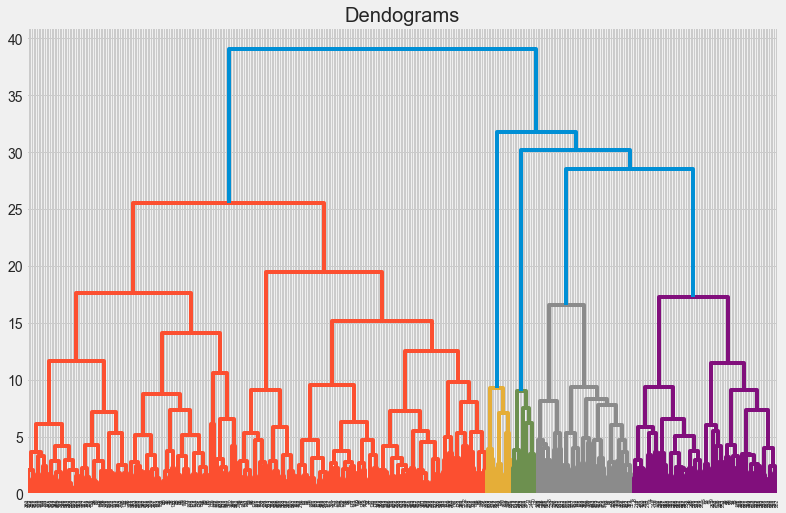

In [125]:
model_AC_5 = do_AgglomerativeClustering(n_clusters=5)

Model labels: [7 7 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 5 5 4 4 2 2 2 4 2 4 2
 6 2 4 4 2 4 4 3 3 3 2 6 3 6 2 2 6 3 2 2 2 6 2 3 2 4 4 6 2 3 4 4 4 4 4 6 4
 2 4 4 2 2 2 4 1 2 1 2 4 1 4 3 4 2 2 7 7 0 1 0 0 0 0 0 0 0 0 1 2 1 0 0 2 5
 5 4 1 1 2 2 2 4 2 2 2 2 2 6 2 4 6 4 6 6 3 2 4 2 2 2 4 2 2 2 2 1 4 2 2 2 3
 3 1 1 2 4 4 1 3 3 3 3 5 5 3 2 2 2 2 2 2 3 2 2 2 6 4 2 3 4 2 2 4 4 6 4 3 6
 4 4 4 6 4 4 2 2 3 2 2 1 3 3 2 6 1 3 6 2 1 6 4 3 1 2 6 5 7 7 1 1 0 0 0 0 0
 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 5 0 0 7 7 7 0 0 1 0 0 0 0 2 1 1 0 0 1 0 0 5
 5 7 0 0 7 1 0 0 0 0 0 0 1 0 0 0 0 0 0 2 2 2 0 0 0 5 2 3 3 3 2 3 3 2 3 3 4
 4 6 2 6 4 3 4 4 4 2 2 1 3 4 3 3 3 6 2 3 4 3 2 1 3 1 4 3 3 3 1 3 5 1 4 2 2
 2 2 4 2 2 2 6 2 6 1 3 4 2 4 3 3 2 3 4 1 2 1 1 3 2 6 2 3 6 6 6 2 3 2 4 3 4
 1 2 3 2 5 3 7 7 7 7 0 0 0 1 0 0 0 0 1 0 1 0 0 2 1 0 2 4 2 2 6 2 6 1 3 1 2
 1 1 3 1 2 1 1 3 4 2 5 4 5 2 4 1 2 1 3 2 2 2 3 1 4 6 2 1 3 3 2 5 4 4 4 6 1
 1 6 2 2 2 4 2 3 3 1 2 6 1 1 3 1 6]
Silhouette score: 0.1361740434924304


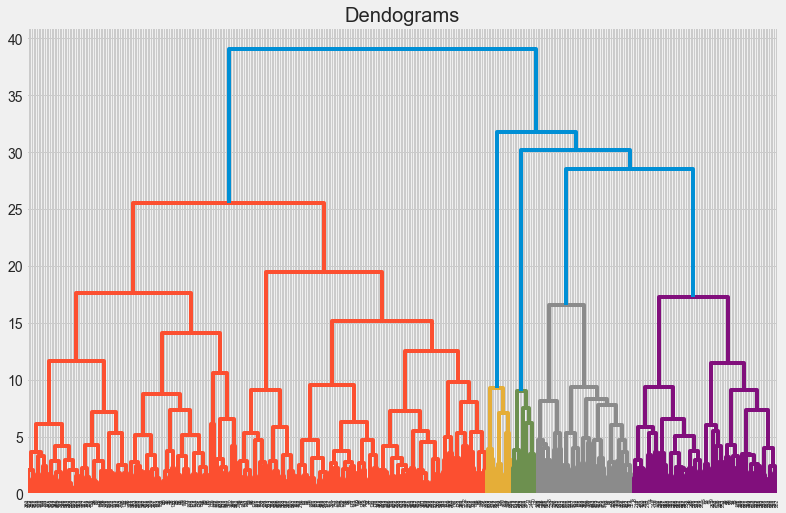

In [126]:
model_AC_8 = do_AgglomerativeClustering(n_clusters=8)

Model labels: [0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1
 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1
 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1
 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0]
Silhouette score: 0.30877478972491856


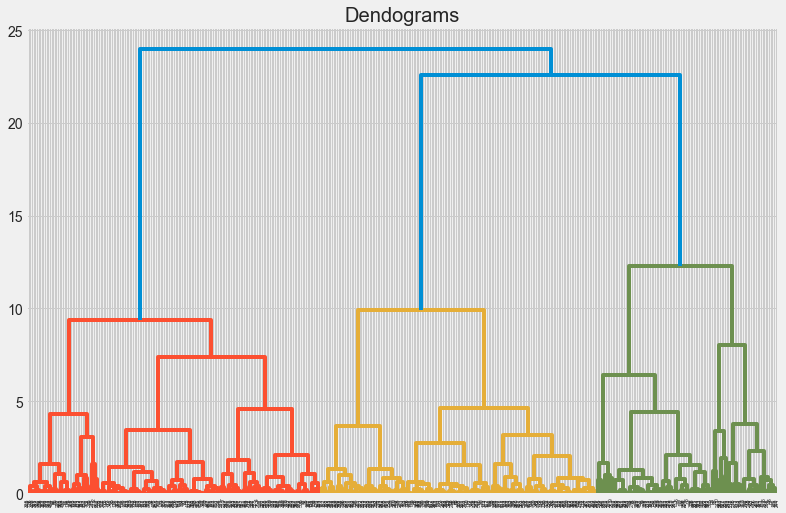

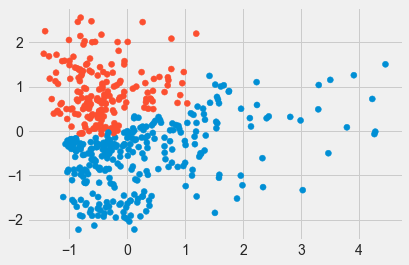

In [127]:
model_AC_PCA_2 = do_AgglomerativeClustering(feat='pca2', n_clusters=2)

Model labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 2 0 2 1 1 1 0 0 2 2 2 2 0
 1 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 2 0 2 0 2 2 2 2 0 0 2 2 2 2 2 0 0 2
 0 1 2 2 0 2 2 0 0 0 0 2 0 2 2 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 2 0 2
 2 1 1 1 2 0 0 0 0 2 0 2 0 0 2 2 0 2 0 0 2 0 1 0 1 0 1 2 0 2 2 0 1 0 0 0 2
 2 0 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0 2 2 2 2 0 2 0 0 2 2 0
 0 0 0 2 1 1 0 0 2 0 0 0 2 2 0 0 0 2 2 0 0 0 0 2 0 2 0 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 0 0 0 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0
 2 0 0 0 0 2 2 2 2 0 0 1 1 0 0 2 0 0 0 1 1 2 0 0 0 0 1 2 2 2 0 2 2 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 2 2 2 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0
 0 0 2 2 2 2 1 1 1 1 1 1 1 0 1 2 1 1 1 2 1 2 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 2 0 2 2 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
Silhouette score: 0.2440245577933055


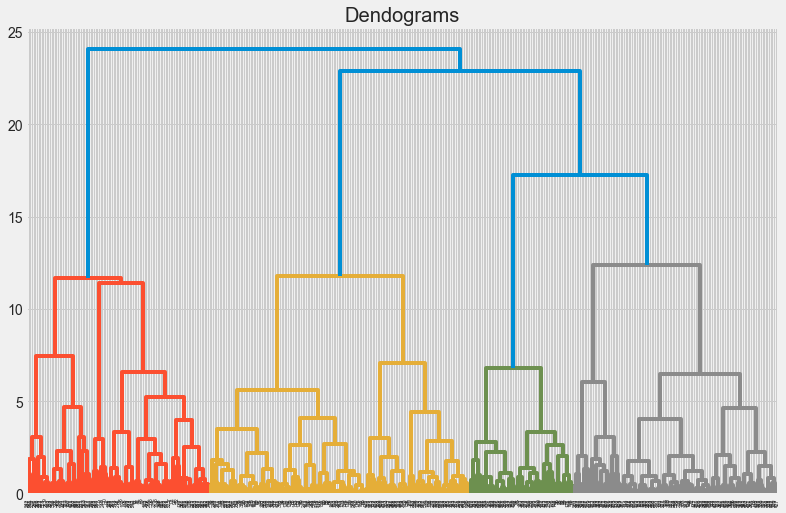

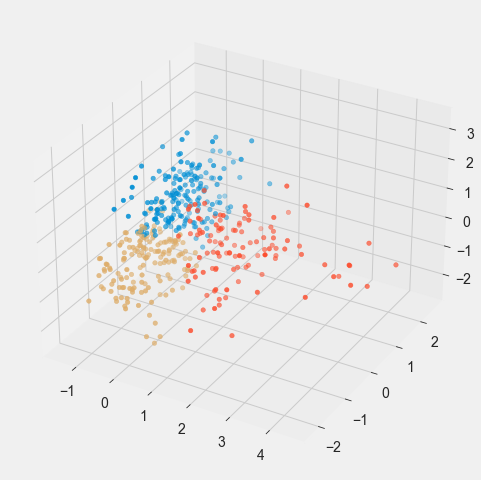

In [128]:
model_AC_PCA_3 = do_AgglomerativeClustering(feat='pca3')

Model labels: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Silhouette score: 0.8108936088598764


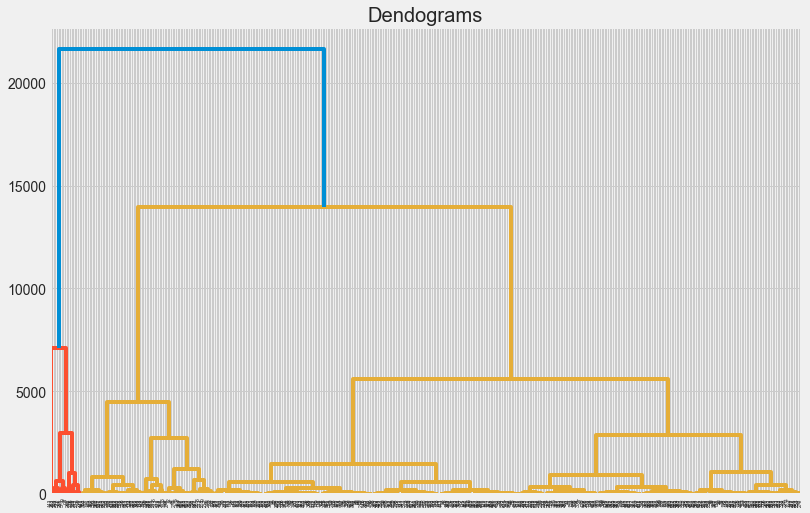

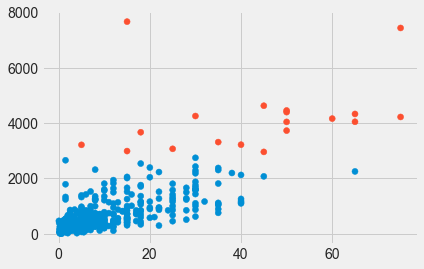

In [129]:
model_AC_SKB_2 = do_AgglomerativeClustering(feat='skb2', n_clusters=2)

Model labels: [0 0 2 2 1 2 2 1 2 2 2 2 2 2 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 0 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 1 2 2 2 2 2 2 1 0 1 2 1 1 1 1
 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 0 1 1 2 2
 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 2 2 2 1 1 1
 2 2 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1 1 2 0 2 1 2 2 1 1 2 1 1 0 2 1 2 2 1 1 1
 2 0 2 2 0 2 2 1 2 2 2 0 0 2 2 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]
Silhouette score: 0.6862170090457618


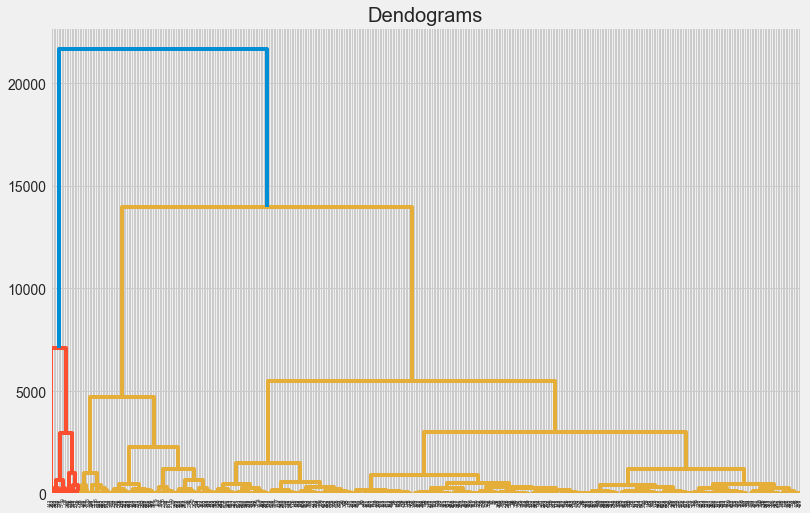

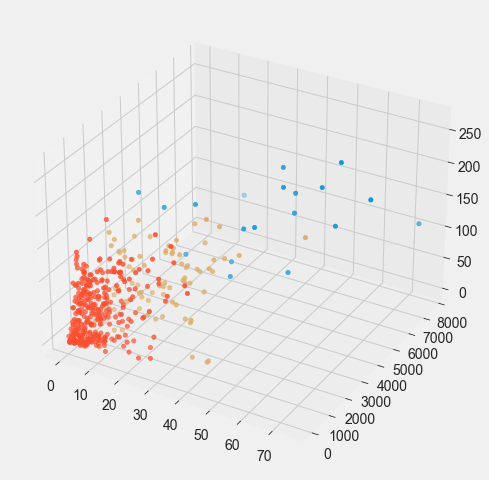

In [130]:
model_AC_SKB_3 = do_AgglomerativeClustering(feat='skb3')

### Mean Shift

In [131]:
def do_MeanShift(feat=None, bandwidth=None, cluster_all=True):
    if feat:
        features = feat
    else:
        features = do_StandardScaling()
    cluster = MeanShift(bandwidth=bandwidth, cluster_all=cluster_all, n_jobs=-1)
    model = cluster.fit(features)
    print(f'Cluster centers: {model.cluster_centers_}')
    return model

In [132]:
model_MS = do_MeanShift()

Cluster centers: [[ 7.21678658e-03  9.40642328e-02 -2.66128799e-01 -2.89852917e-01
  -2.89934467e-01 -1.80085485e-01 -1.24250048e-01 -1.89618185e-01
  -4.30909959e-03  1.37009463e-02 -1.93538087e-01 -1.87947659e-01]
 [-6.91861454e-01  8.67120718e-02  3.93764652e-01 -3.09746011e-01
   3.60825050e-01 -1.08026137e+00  2.79991155e-01  5.27375578e+00
  -6.30530077e-01  9.31094457e-02  3.54418288e-01 -4.12372115e-01]
 [ 1.06004546e+00 -1.18125293e+00  3.25704668e-01  7.41326134e+00
   1.52543050e+00  3.52182704e-01 -1.03923559e+00 -1.89618185e-01
   6.21028009e-01 -5.82850467e-01 -6.60406747e-01 -4.12372115e-01]
 [-7.08706713e-01 -1.80227929e-01  5.22602349e+00  7.16723498e+00
   1.89711309e+00  1.08725269e+00  2.25920781e-03 -1.89618185e-01
  -9.43419598e-01  2.91235627e-01  1.51421833e+00  2.42499423e+00]]


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [133]:
def do_DBSCAN(feat=None, eps=0.5, min_samples=5, metric='euclidean'):
    if feat == 'pca2':
        features = features_PCA_2
    elif feat == 'pca3':
        features = features_PCA_3
    elif feat == 'skb2':
        features = features_SKB_2_chi2
    elif feat == 'skb3':
        features = features_SKB_3_chi2
    else:
        features = do_StandardScaling()
    cluster = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
    model = cluster.fit(features)
    print(f'Model labels: {model.labels_}')
    if len(np.unique(model.labels_)) > 1:
        print(f'Silhouette score: {silhouette_score(features, model.labels_)}')
    if feat == 'pca2' or feat == 'skb2':
        plt.figure()
        plt.scatter(features[:, 0], features[:, 1], c=model.labels_)
    elif feat == 'pca3' or feat == 'skb3':
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=model.labels_)
    return model

In [134]:
model_DBSCAN = do_DBSCAN()

Model labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

Model labels: [-1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1 -1  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0 -1 -1  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 

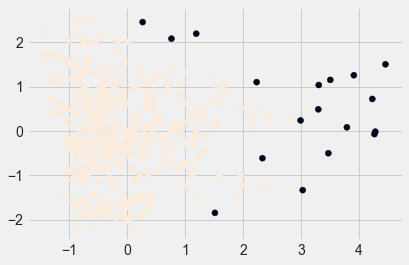

In [135]:
model_DBSCAN_PCA_2 = do_DBSCAN(feat='pca2')

Model labels: [-1 -1 -1  2 -1  0  1  1  1  4  0  0  0  0  1  1 -1  1  0  1  1  1  1  1
 -1  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  3
  2  1  2  1  1  1  1  2  3  1 -1  1  1  1 -1 -1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  3  3 -1
 -1  2  1  1  1  1 -1  1  4  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
 -1 -1 -1  2  1 -1  1  1 -1  1 -1 -1  4  1 -1  1  1  1 -1 -1 -1  2  1 -1
 -1  1  1  1 -1  1 -1 -1  1  4  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1 -1  1 -1  1  1 

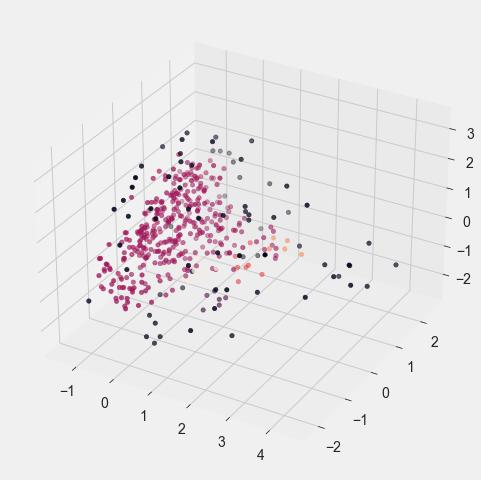

In [136]:
model_DBSCAN_PCA_3 = do_DBSCAN(feat='pca3')

Model labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

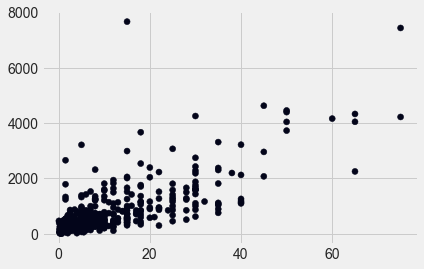

In [137]:
model_DBSCAN_SKB_2 = do_DBSCAN(feat='skb2')

Model labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

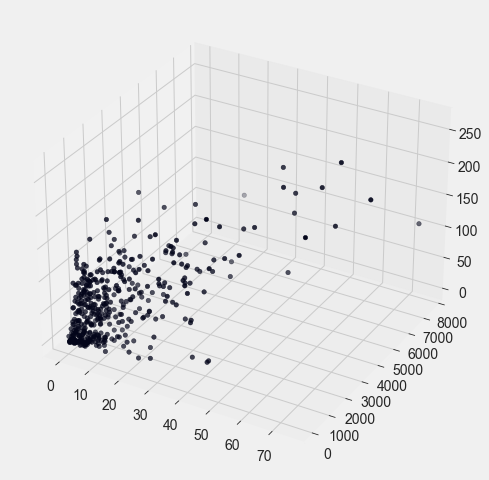

In [138]:
model_DBSCAN_SKB_3 = do_DBSCAN(feat='skb3')

### OPTICS (Ordering Points To Identify the Clustering Structure)

In [139]:
def do_OPTICS(feat=None, eps=None, min_samples=5, metric='minkowski'):
    if feat == 'pca2':
        features = features_PCA_2
    elif feat == 'pca3':
        features = features_PCA_3
    else:
        features = do_StandardScaling()
    cluster = OPTICS(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
    model = cluster.fit(features)
    print(f'Model labels: {model.labels_}')
    print(f'Silhouette score: {silhouette_score(features, model.labels_)}')
    if feat == 'pca2':
        plt.figure()
        plt.scatter(features[:, 0], features[:, 1], c=model.labels_)
    elif feat == 'pca3':
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=model.labels_)
    return model

Model labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 23 -1 -1 -1  8 -1 -1 -1 20 -1 -1 -1  7
  4 14 20 -1  1 -1 14 -1 -1  8 -1 -1 17 -1  5  7 -1 -1 -1 10 21 22 22 -1
  7 11 11 -1 -1 13 12 12 16 -1 -1 -1 -1 16 -1 12 -1 17 -1 -1 12 -1 -1 14
  7  6 -1  8 -1  6 -1 10 -1 -1  7 -1 17 -1 -1 -1 11 12 -1 -1 -1 -1 -1  0
 -1 -1 -1 -1 -1 -1 -1 -1  0 24 -1 19 -1 -1 -1 -1 -1 -1 -1  5  9 -1 -1 -1
  6  7 10 24  4 -1  2 -1 -1  7 -1 22 -1 -1 -1 18 -1 18 -1 24 -1 -1 -1 -1
  5 24 24 20 -1 15 -1 -1  2  7 -1 -1 -1 -1 -1 -1 -1 -1 16 13 -1 12 -1 16
 -1 -1 13 -1  2 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 22 13  3 -1  6 -1 -1 -1 -1
 14  5 -1 -1 -1  4  5 -1 -1 20 20 -1 -1 -1 -1  7 -1  4 16 13 -1  0 -1 -1
 -1 -1 -1 15 -1 18 -1  1 23  1 -1 -1 -1  8 -1 22 -1 -1 21 22 -1 -1 19 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 23 18 -1 -1 -1 -1 20 -1 -1 -1 -1 -1
 -1 -1 15 -1 -1 15 -1  0 15 23 -1 -1 18 19 -1 -1 -1 22 21 -1 -1 -1 13 -1
 13 13 12 -1 -1 13 -1  2  4 10 12  4  6 -1 -1 -1 -1 17 -1 23 -1 18  5 -1
  2  9 -1 -1 -1 -1 -1 19  3 -1 -1 -1 

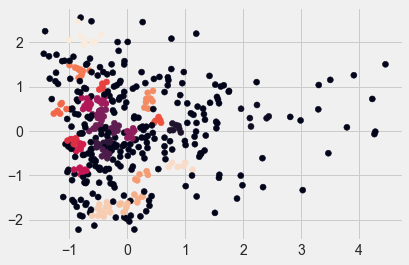

In [140]:
model_OPTICS_PCA_2 = do_OPTICS('pca2')

Model labels: [-1 -1 -1 14 -1 16 -1 -1 -1 15 16 16 16 16 -1 -1 -1 -1 16 12  2 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  2 -1  2 -1 -1 -1 -1 -1 -1 -1
  7 -1 -1 -1 -1  4 -1  5 10 -1 -1 -1 -1 10 -1  5 -1 -1 -1 -1 -1 -1 -1  9
  7 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1  2 -1  5  5 -1 -1 -1 -1  0
 14 -1 14 -1 -1  1  1 14  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1
 -1  7 -1 -1 -1 -1  2 -1 -1 -1  3 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 12 -1 -1 -1  4  2 -1 -1 12 -1 -1 -1 -1 -1 -1 10  4 -1  5  4 10
 -1 -1  4  5 -1 -1  4 13 -1 -1 -1 -1 -1 -1 -1 -1  3  6 -1  6 -1 -1 -1  9
 -1  2 -1  9 -1 -1  2 -1 -1 -1 12 -1 -1 -1  7 -1 -1 -1 10 -1 -1  0  0 -1
 -1 14  1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 12 -1 12 -1 -1 -1
 -1 -1 -1 14  1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1  9 -1 -1 12 -1 -1 -1  5  8
  3  4  3  3 -1  3 -1  6 -1 -1  3 -1 -1 13 -1 -1 -1 11  9 -1 -1 -1 -1 -1
  6 -1 11 -1 -1 -1 -1 -1  6 -1 -1 -1 

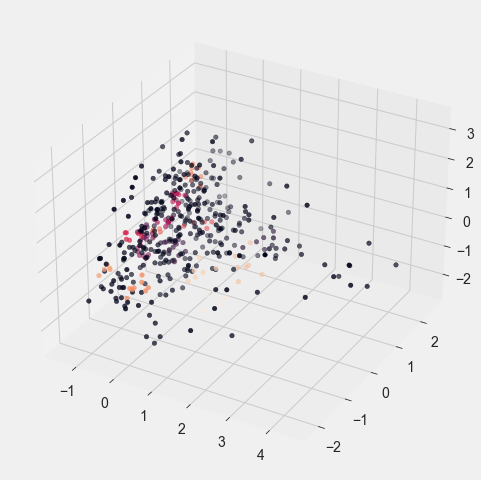

In [141]:
model_OPTICS_PCA_3 = do_OPTICS('pca3')

### Affinity Propagation

In [142]:
def do_AffinityPropagation(feat=None, damping=0.5, affinity='euclidean'):
    if feat == 'pca2':
        features = features_PCA_2
    elif feat == 'pca3':
        features = features_PCA_3
    elif feat == 'skb2':
        features = features_SKB_2_chi2
    elif feat == 'skb3':
        features = features_SKB_3_chi2
    else:
        features = do_StandardScaling()
    cluster = AffinityPropagation(damping=damping, affinity=affinity, random_state=42, max_iter=10000)
    model = cluster.fit(features)
    print(f'Model labels: {model.labels_}')
    print(f'Cluster centers: {model.cluster_centers_}')
    print(f'Silhouette score: {silhouette_score(features, model.labels_)}')
    if feat == 'pca2' or feat == 'skb2':
        plt.figure()
        plt.scatter(features[:, 0], features[:, 1], c=model.labels_)
    elif feat == 'pca3' or feat == 'skb3':
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=model.labels_)
    return model

In [143]:
model_AP = do_AffinityPropagation()

Model labels: [ 6  6  0 22  0  1 22  0 23  9  1  1  1  1  2  2  2  0  1 23  2  7  2  2
  2  2  8 26  3 22 10 19 10  3 10  3 19  9 10  5  3 13  5  5 13 13 13 12
 11  5 12 16 16 12  5 16 16 18 12 18  5 16 17  5 11 18 13 17  5 17  5 18
 11  5 19  3  3 10 19 10  3  4 11  4 18  5  4  5  5  5 16 18  6  6  0 23
  0 22 29  0 22 20  9  0 23  0  7 25 25 24  8  8  9  7  4 10 19 19  3 19
 10  4 10 18 12 10  5 11 17 11 12 13 18  3 19 19 39 32 10 19 10 10 33 14
 12 39 18 13 13 33  4 16 17  5 34 13 13 35 17 15 15 35 16 16 16  5 16 16
 35 18 16  5 12 17  5 13 17  5 18 17 17 11 17 13 12 17 17 17 11 22  9 19
 19 10 19 19 33 10 10 19 11 33 13 12 16 33 12 17 35  4 16 12 40 20 20 21
 23 22 22 29 29 29 29 23 30 29 22 31 24 29 29 25  2 25 25 25 25 26 25 25
 27  6 30 29 22  7 29 29 31 31 24 21 23 29 30 23 31 31  8 26 27 29 29 28
 23 22 29 29 30 29 30 21 29  1 29 29 31 29 31 31 31 25 25 25  8 16 16 12
 16 16 16 16 16 16 35 37 37 36  5 36 37 13 37 37 37 18 19 41 10 32 42 35
 37 36 38 29 32 35 32 33 37 34 32 35 

Model labels: [ 7  7  8  0 17  1  0 17  2  1  1  1 11  2 22 22 22 17  1 13 22  2  5 20
  3  4  6 10  2  8 12 19 20 22 20  6 21 22 20 20 22  6 14 18 13 15 15 21
 20  5  5 18 21 14 14 14 18 21 18 21  5 18  3 14 18 21  5  3 14 14 14 12
 20 14  4 22 22 20 12 18 22 22 20 20 21 20  3  3  5 14 14 21  7  7 17  0
  2  0  2  0  0  0  2 17 16 19 10  6 13  4  6 13  1  2 11 20 12 12 12 12
 20 20 12 19  3 14  3 20  5 20 14 15 19  1  4 17  4 11 22 19  3 20 11  0
 20 19 19 13 15 11 22 14  3 20 13 13  5 15  5 13 13 15 18 14 18 14 14 18
 15 21 14 14  3  3 14 15  5 14 21  5 14  3  3 15 14  3 14 20  6  0  2  4
 12 20  4 12  2  3 22 21 12 13 13  5 20  6 18 20 15  3 18 14  3 16 16 16
  2 17  0 11  4 17  1  2  1 11  2 12 12 22  3 13  3 13 13 13 13 10  6 13
  9  7 10  2  0 10 17  4  8  4 19 10  1 17  1  2  4  3  6 10  9  2 17  9
  1  0 11  2 10 11 10 16 11  1 22 11 11  6  4  4 12 15 13 15 13 18 14  5
 14 14 14 14 21 14  5  3  3 18 14  3 20 15 22  5  6 21 12  1 11 11 22  6
  3 12  4 11 11  5 12  6  3 13  1  5 

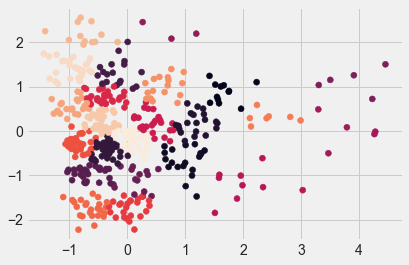

In [144]:
model_AP_PCA_2 = do_AffinityPropagation(feat='pca2')

Model labels: [ 5  5  7 13  1  0 13  1 26 14  0  0  0  0  8  8  8  1  0 15 11 30  8  2
  8  1 18  0 26  1  2  7  8 11  8 20  4 10 11  2  8  8  3  2 15 12 15  4
 23  3 20  2  4  3  3  3  2 27 23  4  3  2 20  3 23  4 12 20  3 20  3  4
 23  3  4 11 26  2  4  2 11 10 23 22  4  2 10 11  3  3  3  4  5  5  1 13
 13 13  0 13 13 13 13 26 25  7 16  8 15 27 18 18 30 25 30 11 23  4  6  6
  2 23  2  7 24  3 11 22 20 22 24 12  7 14  7  6 27  6  8  7  8  2  9 13
 11 27  7 15 12  9 10  3 11 11 21 15 12 12 20 15 15 12  2  3  2  3  3  2
 12  4  3  3 10 24  3 21 20  3  4 20 24 10 20 21 24 24 24 24 10 13 25  6
  4 11  4  2  9 20 11 27 22 31 15 10 23 29 23 23 12 10  2 24  8 25 17 25
 25  1 13 26  1  6 14 30 14 26 26  6 22  8  8 15  8 15 15 12 15 14 15 15
 17  5 14 26 13 16  6  6  6  6 27 16 14  6 14 30  6  8 18 18 17 13  6 17
 19 13 26 26 14 26 14 25 26 14  8  8  6  8  7  6  2 12 15 12 18  4  3 24
 24  3 24 24 23 24 20 24 20 22 24 10 24 21 24 10 21 27  6 19 11 30 11 20
 24 22 27 11 22 20 22 29 24 31 30 20 

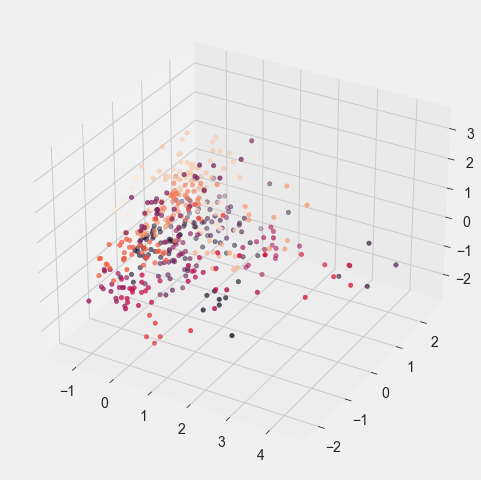

In [145]:
model_AP_PCA_3 = do_AffinityPropagation(feat='pca3')

Model labels: [ 2  2 12  4  8 12 10  7  0  0  0 12  0  8  7  1  7  8 12  1  1 10 13  1
  1  1  1 17  8  3 14  7 14 13 14  7 14  7  1 15 13  5 14 15  7 14 15 15
 14 13 13  1 15 13 15 14 15 14 15 15 15 15  6 15 14  7 15 15 15 15 15  7
 14 14  6 13  6 14 15 15 14 13 13 13 14 14 14  1 15 15 15 14 16  2  5  3
  8 12  5  4  4 17  4  8 16  7 17  6  1  7  7  8  0 12  6  7 14 14  7  7
 15 14 14 14 13 14 13 13 14 14 14  1 14  5  7  6  1  7  5  1  6 13  6 11
  7  1  5  5 13  8 17 14 13  7 13  5 14 15 14 13 13 15 15 15 15 15 15 15
 15 15 15 15  1 14 15 15 15 15 15 15 15 14  7 14 15 14 15 14 15  3  0 12
  7 13  6  7 12  7  6  1  1  6  1 13 13  6 13  7 14 13 15 14 14 10  3  3
  5  0  0  1  6  6 17  5 17 17 10  8  8  8 17 13 13 17  1  7 13 17  6  1
 10 16 10  8  5 10  1  1 10  1  7 16 17  8 12 12 13  7 13 17  9 10 12 11
 12 10  8 12  4 17  9  3 12  0  6  6 12  8  0  8  8 14  8 13  8 15 14  6
 14 13 14 14 14 15 15  1  6 13 14  1 13 14  5 13  6  1  7  6  1  7 13 13
  7 13 13 17  8 14  6  1 14 13 10 14 

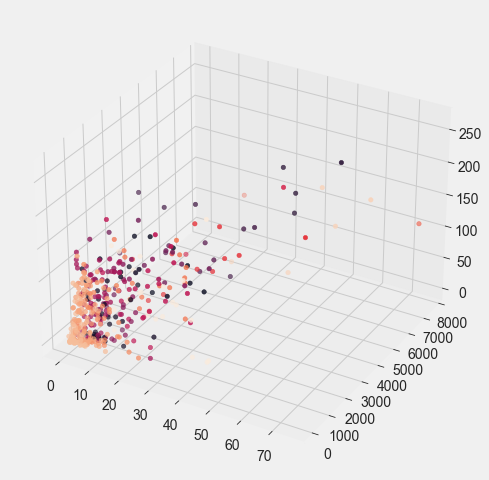

In [146]:
model_AP_SKB_3 = do_AffinityPropagation(feat='skb3')

<br><br><br>